-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : C:\Users\maichi\work\my_projects\CercareStatAnalysis\data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "CTH"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: CTH_lésion, CTH_control, CTH_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

### 3.1 Check for missing values

Fully usable rows in train: 179/182 (98.4%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
CTH_lésion,0.5,0.0
CTH_control,1.6,0.0
CTH_ratio,1.6,0.0


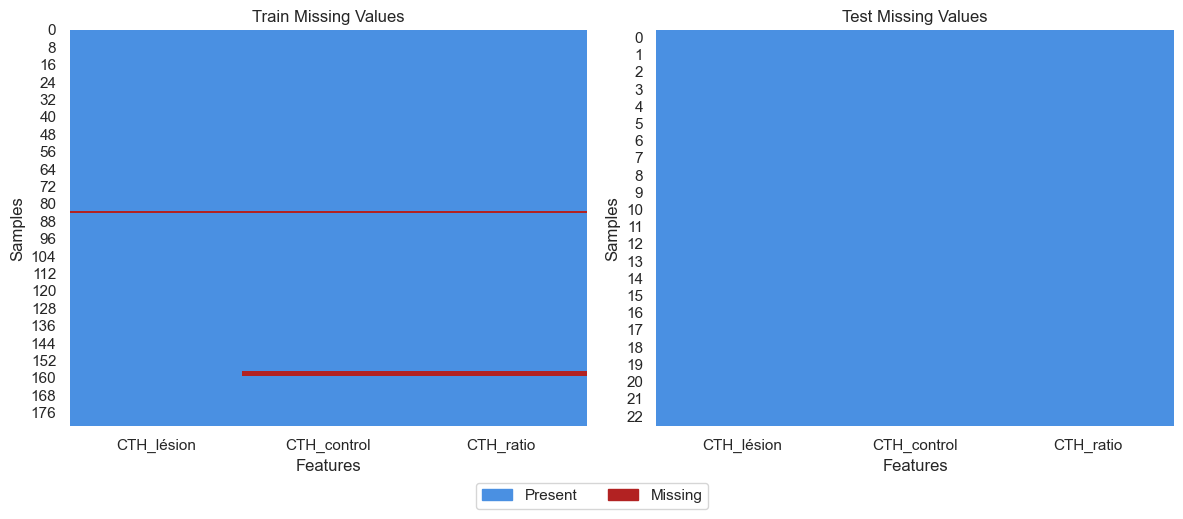

In [6]:
ub.check_missing_data()


### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH_lésion,181.0,3.112707,2.352736,0.06,1.350,2.23,4.13,12.40
CTH_control,179.0,3.415927,2.271639,0.08,1.775,2.90,4.65,16.86



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CTH_lésion,0,110.0,1.736545,1.038348,0.06,1.110,1.495,2.100,7.14
2,CTH_lésion,1,71.0,5.244789,2.228951,1.97,3.665,4.630,6.450,12.40
1,CTH_control,0,108.0,4.350130,2.355555,0.80,2.865,4.170,5.065,16.86
3,CTH_control,1,71.0,1.994887,1.116165,0.08,1.270,1.770,2.165,5.67


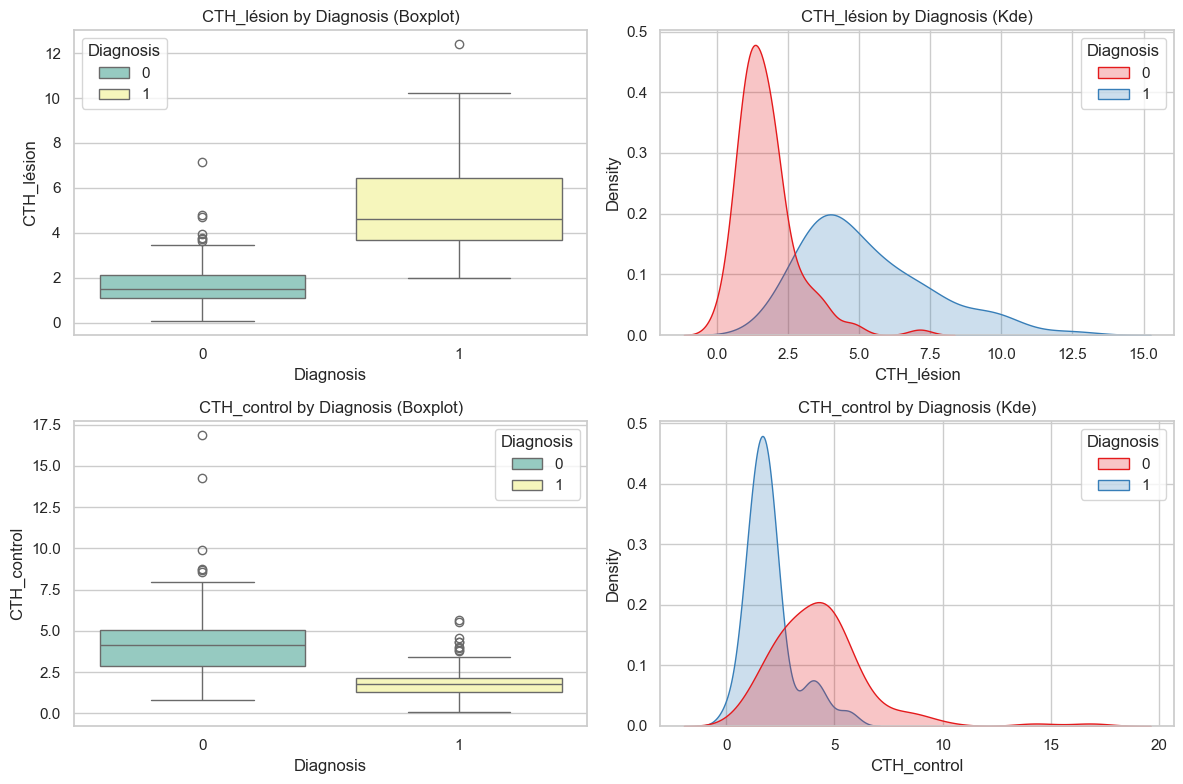

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

#### 🔍 What we check

1. **Pearson correlation** (linear relationship)  
   Measures the strength of a **linear** association between `Path` and `Control`.

   $$
   r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

2. **Spearman correlation** (monotonic relationship)  
   Applies the Pearson formula to the **ranked values** rather than raw values.

   $$
   \rho = \frac{\text{Cov}(\text{Rank}(X), \text{Rank}(Y))}{\sigma_{\text{Rank}(X)} \cdot \sigma_{\text{Rank}(Y)}}
   $$

   This makes Spearman suitable for detecting **monotonic relationships** that are not necessarily linear.

3. **Statistical significance** (p-values)  
   For both Pearson and Spearman, a **p-value** tests the null hypothesis that the correlation is zero (i.e., no association exists):

   - A **low p-value** (typically < 0.05) indicates that the correlation is **statistically significant**  
   - A **high p-value** means there is **insufficient evidence** to conclude that a statistically significant correlation exists
     

In [9]:
ub.describe_features(features=[ub.ratio])

Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH_ratio,179.0,1.573356,2.958792,0.065934,0.390515,0.486063,2.369844,36.25



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CTH_ratio,0,108.0,0.404625,0.12598,0.065934,0.334959,0.412844,0.473827,0.740458
1,CTH_ratio,1,71.0,3.351145,4.11387,1.502693,2.192082,2.713542,3.174205,36.250000


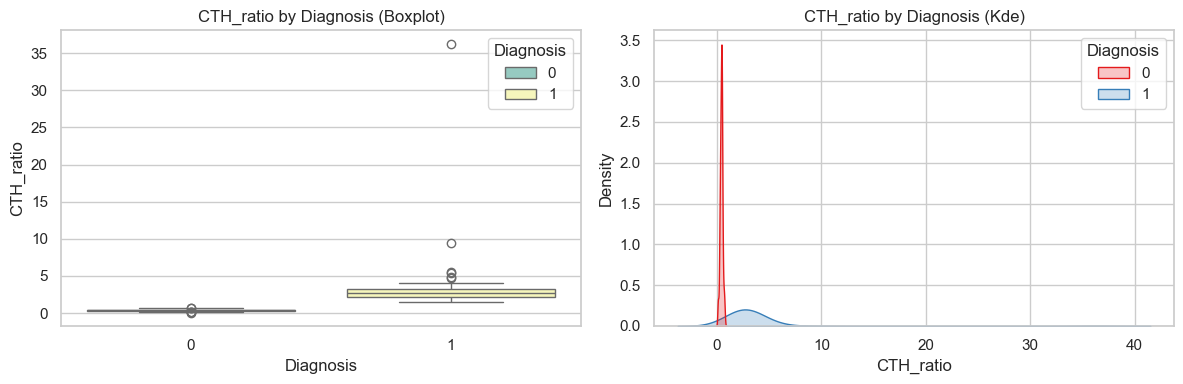

In [10]:
ub.plot_feature_distributions(features=[ub.ratio], plots=["boxplot", "kde"])

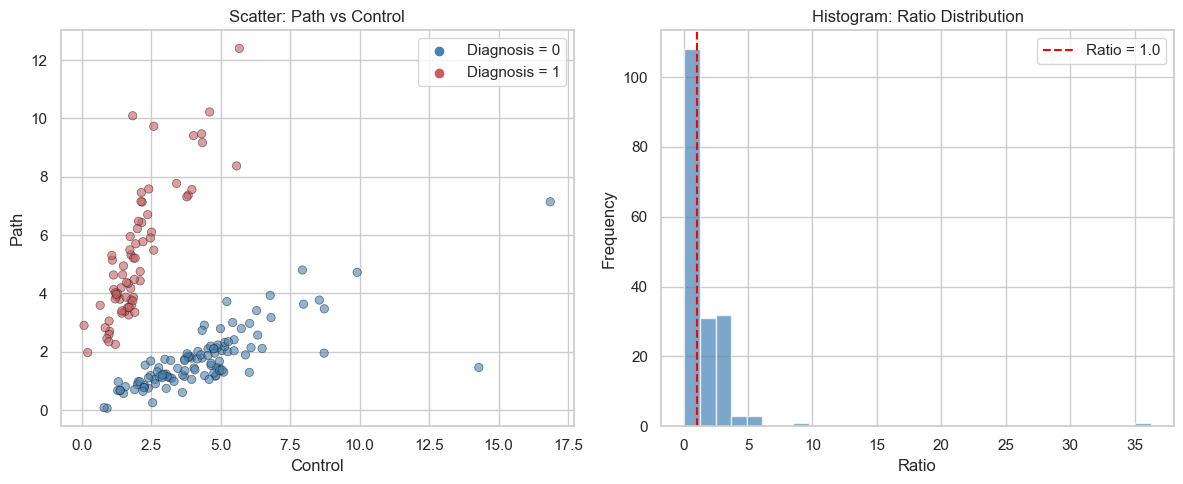

In [11]:
ub.plot_diagnostic_scatter_and_ratio()

In [12]:
ub.evaluate_path_control_correlation()

🔍 Analyzing Biomarker: CTH
------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 1: Correlation Analysis between Path and Control 
------------------------------------------------------------------------------------------------------------------------------------------------------
- Pearson  correlation: r = 0.000, p = 0.9953
- Spearman correlation: r = -0.089, p = 0.2379

------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 2: Interpretation Guidance 
------------------------------------------------------------------------------------------------------------------------------------------------------
Neither Pearson nor Spearman correlation is statistically significant ! 
No clear association between Path and Control ! 
The ratio is a worthwhile feature to explore ! 


## 4.  Discriminative Power of the Biomarker


In this section, we assess whether features like `path` and `ratio` can **discriminate between diagnostic groups**, such as Tumor Recurrence and Radiation Necrosis.

---

#### Step 1 – Normality Check

We start with **Q–Q plots** to visually evaluate whether the distribution of the feature within each group appears **approximately normal**. This helps decide whether we can meaningfully apply a parametric test that models the **data distribution**.

---
#### Step 2 – Choosing the Right Statistical Test

- If the feature appears **normally distributed** in each group, we apply a **Welch’s t-test**.
  - This test assumes the data follows a normal distribution and compares the **means** between groups.
  - Using a parametric test like this is valuable because it lets us **model the data with a known distribution**

- If the feature **does not appear normally distributed**, we instead use the **Mann–Whitney U test**.
  - This is a **non-parametric** test that compares whether values in one group tend to be higher or lower than in the other.
  - It doesn’t assume any specific distribution and works on **ranked data** rather than actual values.
  - But it doesn’t let us **model or describe the underlying distribution** of the data 

---

#### Step 3 – Interpreting the Results

If either test reports a **statistically significant difference** (typically p < 0.05), it suggests that the feature behaves differently between groups — a necessary condition for it to be useful as a biomarker

### 4.1. Distribution Differences: Path Feature

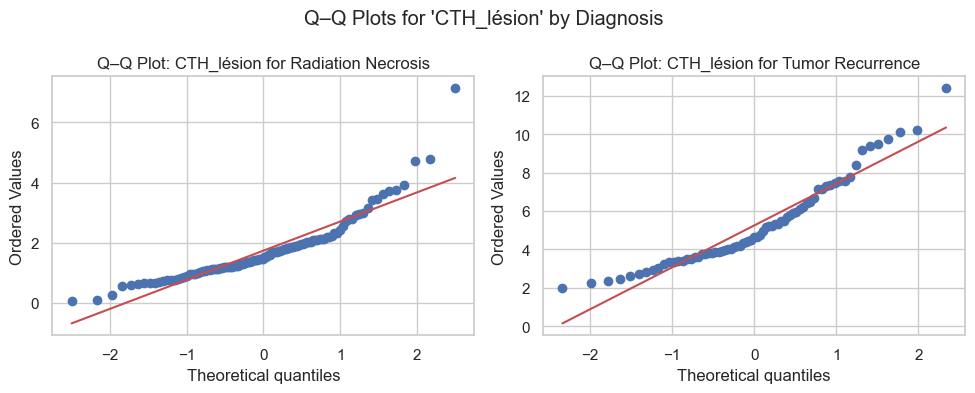

In [13]:
ub.plot_qq_by_group(feature=ub.path)

In [14]:
ub.test_group_difference(feature=ub.path)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -12.4209, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 314.5000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'CTH_lésion'
--------------------------------------------------------------------------------
AUC (Train) : 0.960  (95% CI: 0.934 – 0.985)
AUC (Test)  : 0.804  (95% CI: 0.519 – 1.000)

 Optimal threshold (Youden’s J): 2.250
 Classification Rule          : Class = 1 if CTH_lésion ≥ 2.250

▶ TRAIN SET METRICS AT THRESHOLD: 2.250
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      88.4
Recall (Sensitivity) |      98.6
Specificity          |      81.8
Precision            |      77.8
F1 Score             |      87.0

▶ TEST SET METRICS AT THRESHOLD: 2.250
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      39.1
Recall (Sensitivity) |      85.7
Specificity          |      18.8
Precision            |      31.6
F1 Score             | 

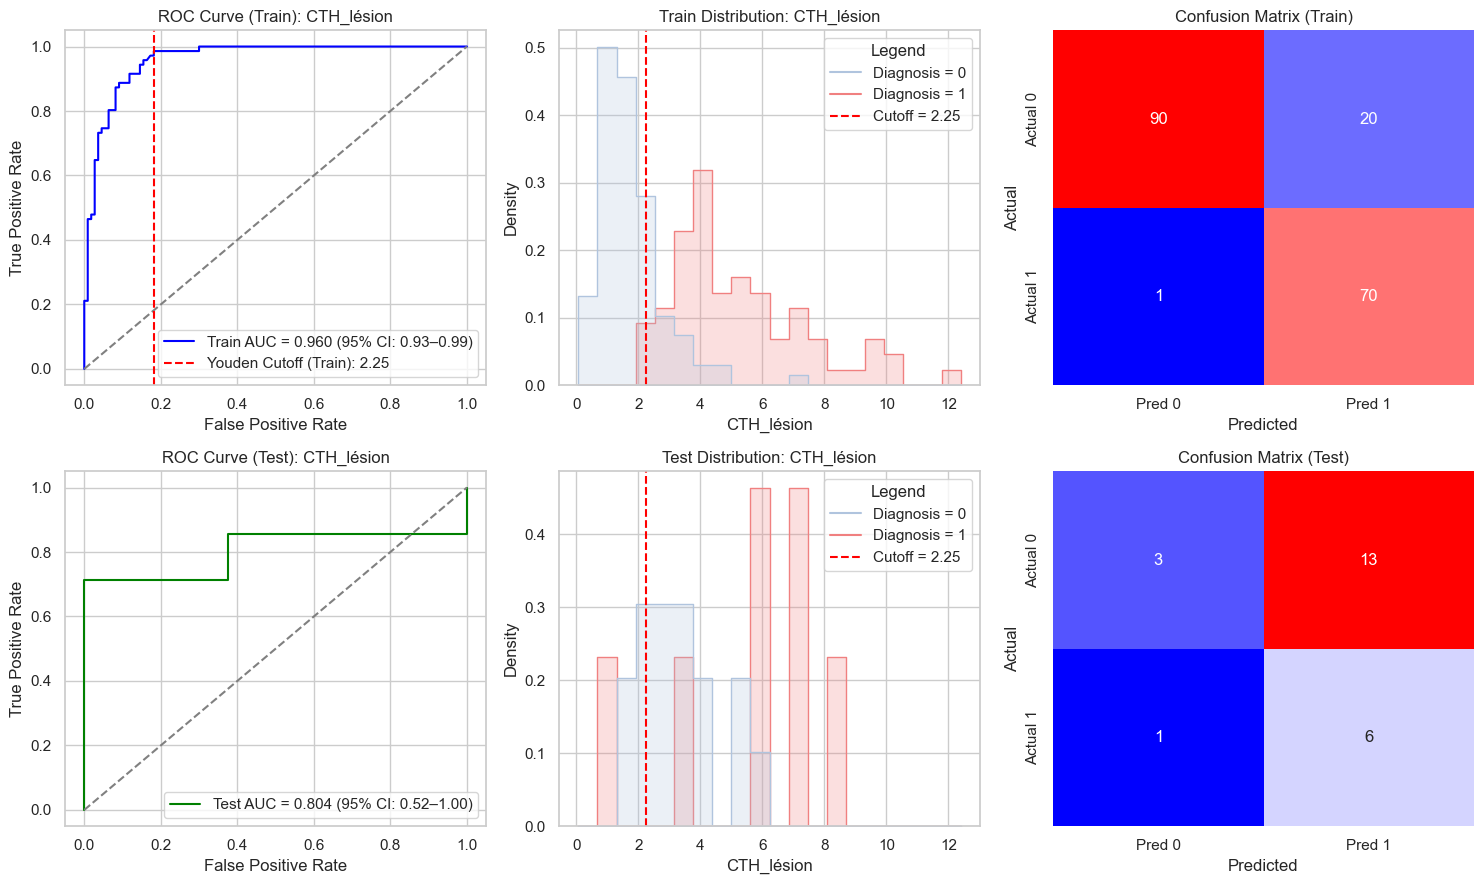

In [15]:
ub.evaluate_feature_predictive_power(feature=ub.path, target_bin_count=20)

### 4.2. Distribution Differences: Path Feature

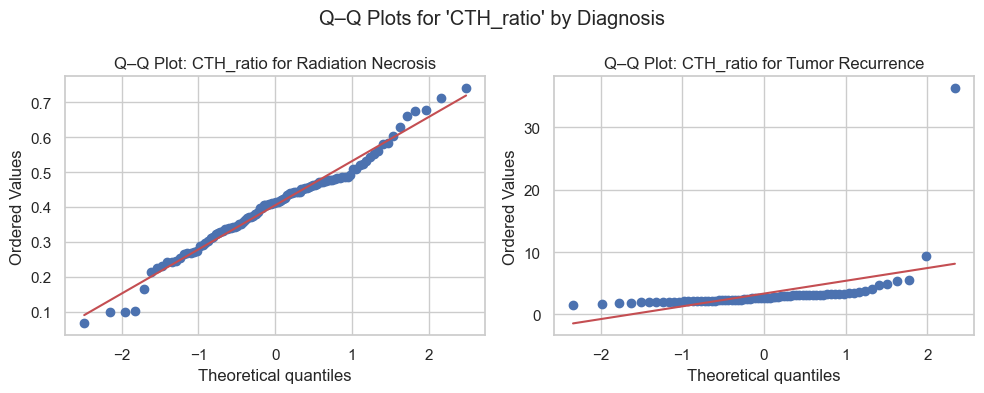

In [16]:
ub.plot_qq_by_group(feature=ub.ratio)

In [17]:
ub.test_group_difference(feature=ub.ratio)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -6.0333, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 0.0000, p = 0.0000   → ✅ Significant difference


Covariance of AUC is 0.0; defaulting to a small delta for CI computation.

🔎 [ROC-Based Classification] Feature: 'CTH_ratio'
--------------------------------------------------------------------------------
AUC (Train) : 1.000  (95% CI: 1.000 – 1.000)
AUC (Test)  : 0.741  (95% CI: 0.457 – 1.000)

 Optimal threshold (Youden’s J): 1.503
 Classification Rule          : Class = 1 if CTH_ratio ≥ 1.503

▶ TRAIN SET METRICS AT THRESHOLD: 1.503
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ TEST SET METRICS AT THRESHOLD: 1.503
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      52.2
Recall (Sensitivity) |      85.7
Specificity      

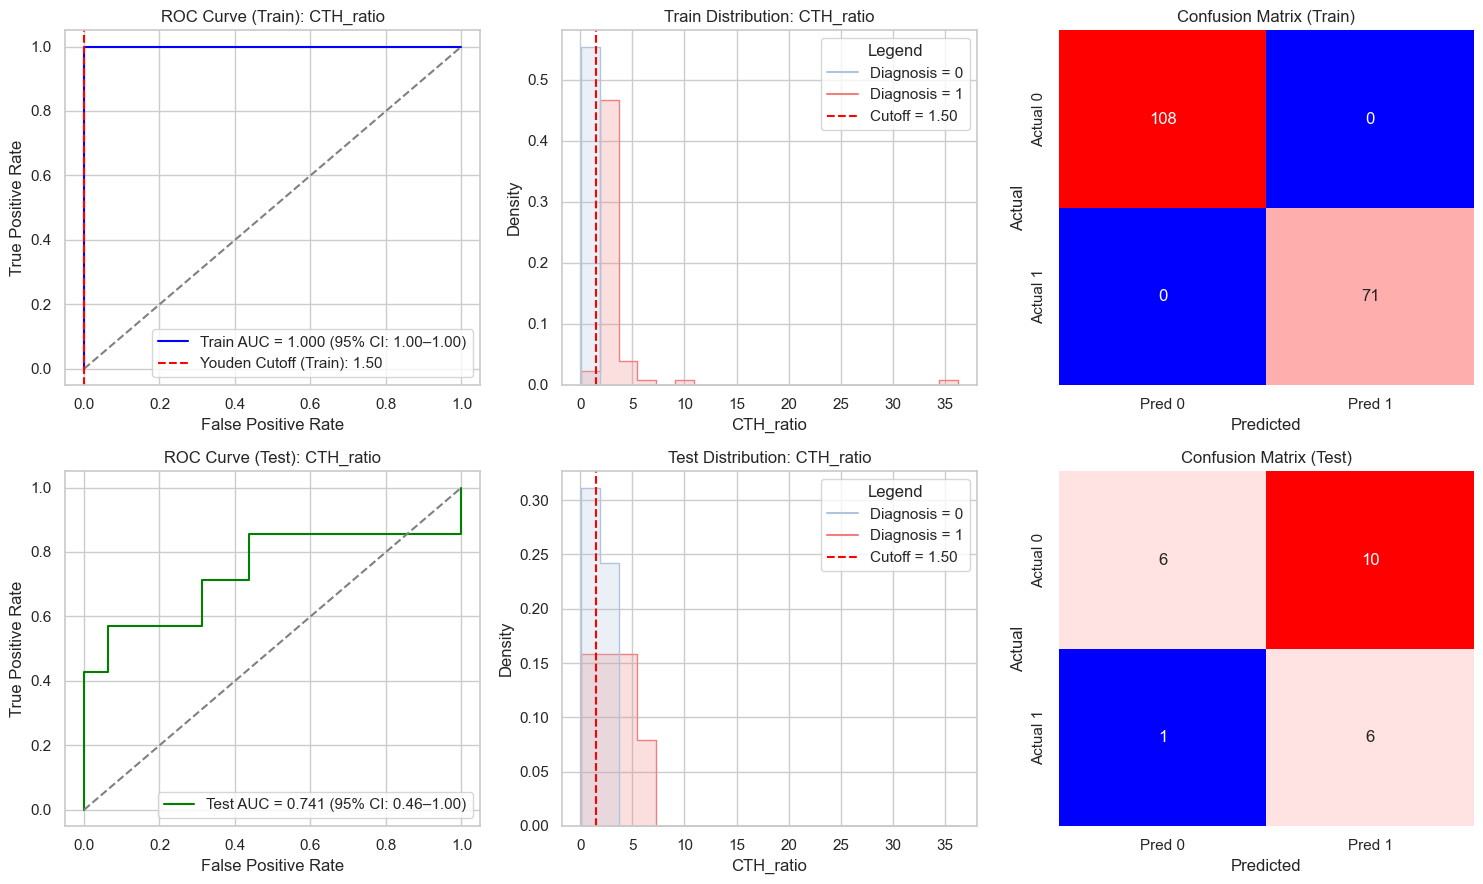

In [18]:
ub.evaluate_feature_predictive_power(feature=ub.ratio, target_bin_count=20)

## 5.  Logistic Regression Modelling

### 5.1 Univariate Logistic Regression 


Logistic Regression Summary for Feature: CTH_lésion
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 1.6815
Odds Ratio           : 5.3734
Youden's J Threshold : 0.1556
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 5.3733
95% CI for OR             : (3.2922, 8.7699)
p-value                   : 1.7282e-11
----------------------------------------------------------------------------------------------------

▶ [CTH_LÉSION] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      90.1
Recall (Sensitivity) |      87.3
Specificity          |      91.8
Precision            |      87.3
F1 Score             |      87.3

▶ [CTH_LÉSION] TRAIN @ YOUDEN
--------------------------------------

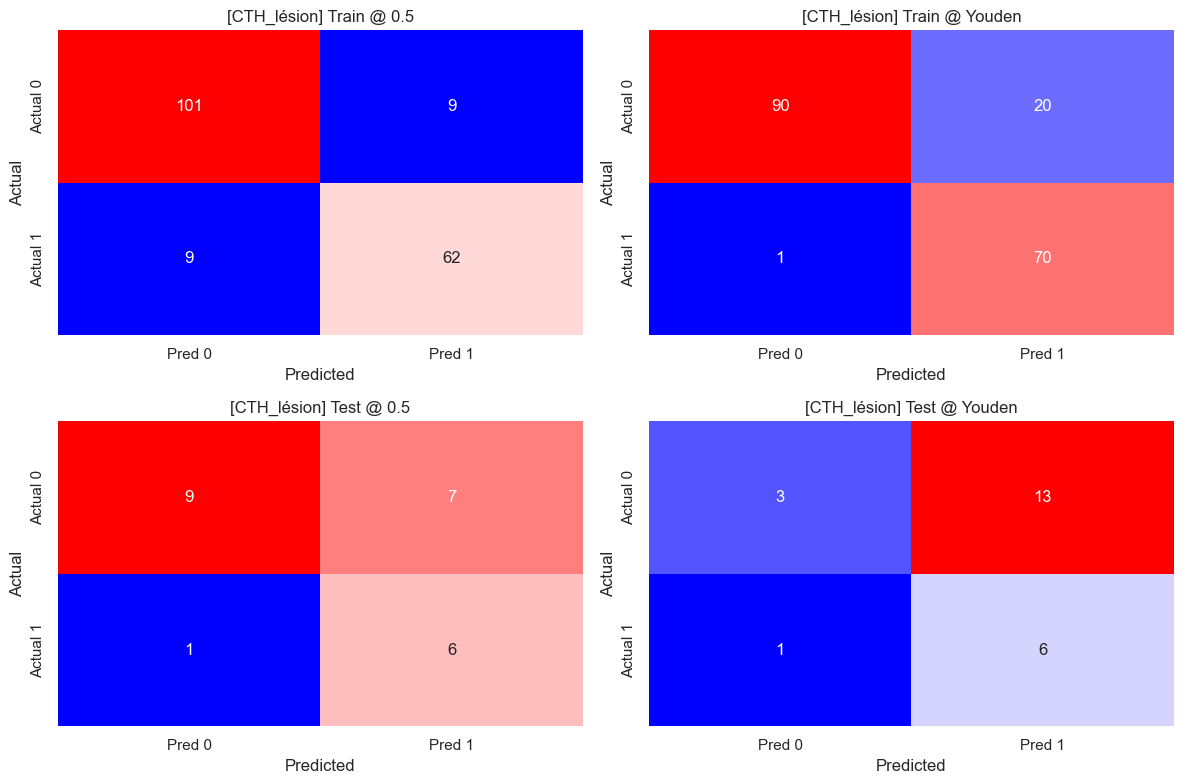

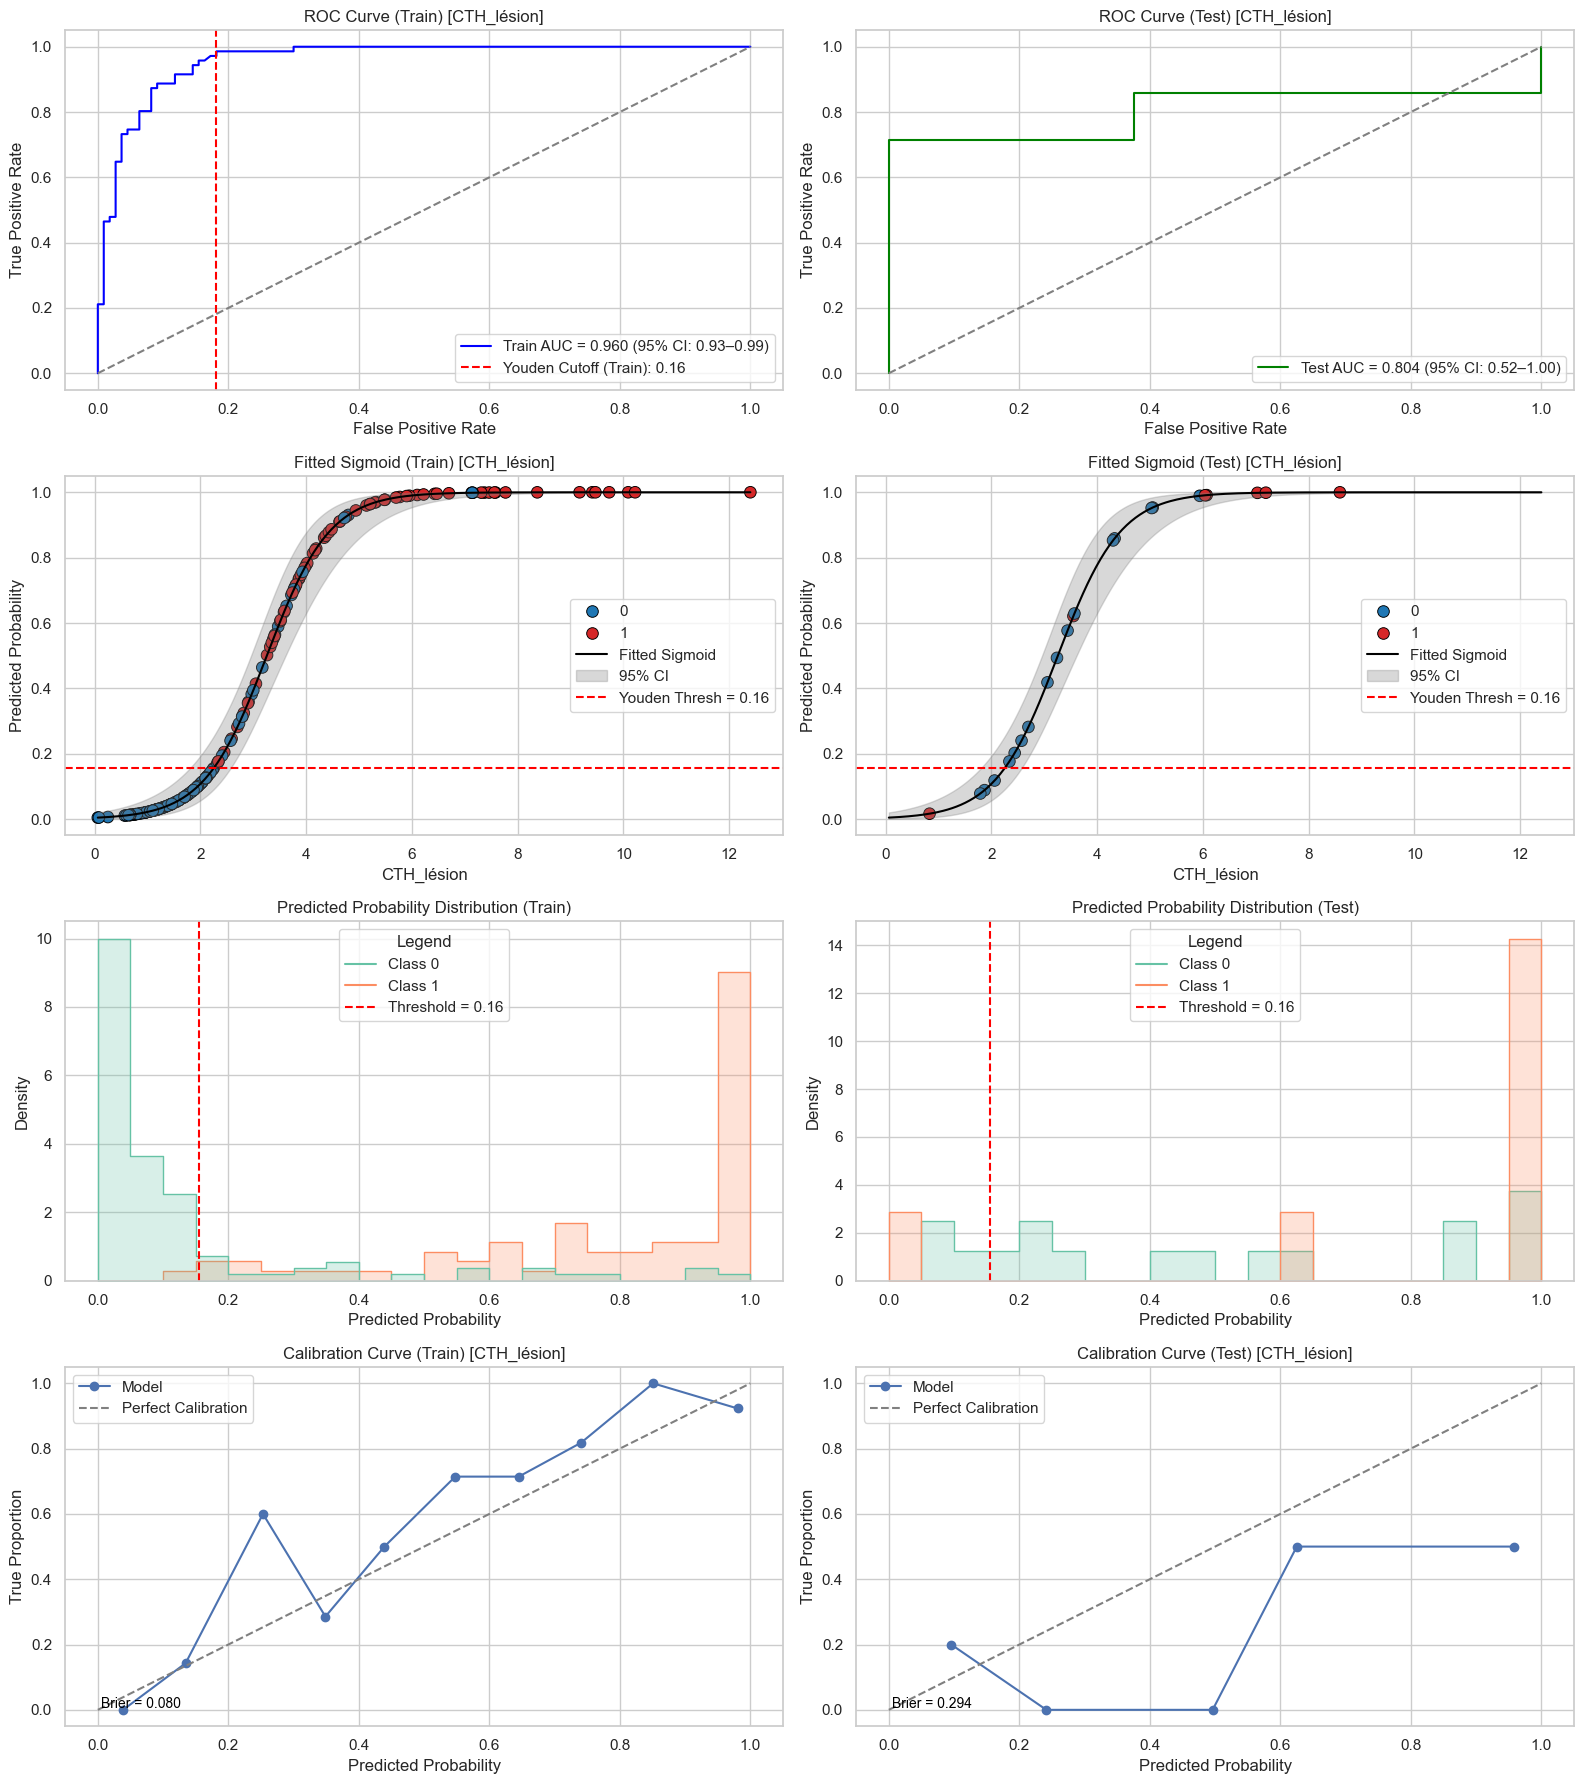

In [19]:
ub.evaluate_logistic_univariate_model(feature=ub.path, target_bin_count=20)

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.

Logistic Regression Summary for Feature: CTH_ratio
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 27.2985
Odds Ratio           : 717113130610.0657
Youden's J Threshold : 0.9999
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 978881304286411393121386496.0000
95% CI for OR             : (0.0000, inf)
p-value                   : 9.9981e-01
----------------------------------------------------------------------------------------------------

▶ [CTH_RATIO] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     1

C:\Users\maichi\anaconda3\envs\cercare\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\maichi\anaconda3\envs\cercare\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maichi\work\my_projects\CercareStatAnalysis\unibiomarker.py:228: RuntimeWarning: overflow encountered in exp
  ci_low_exp, ci_high_exp = np.exp(ci_low), np.exp(ci_high)


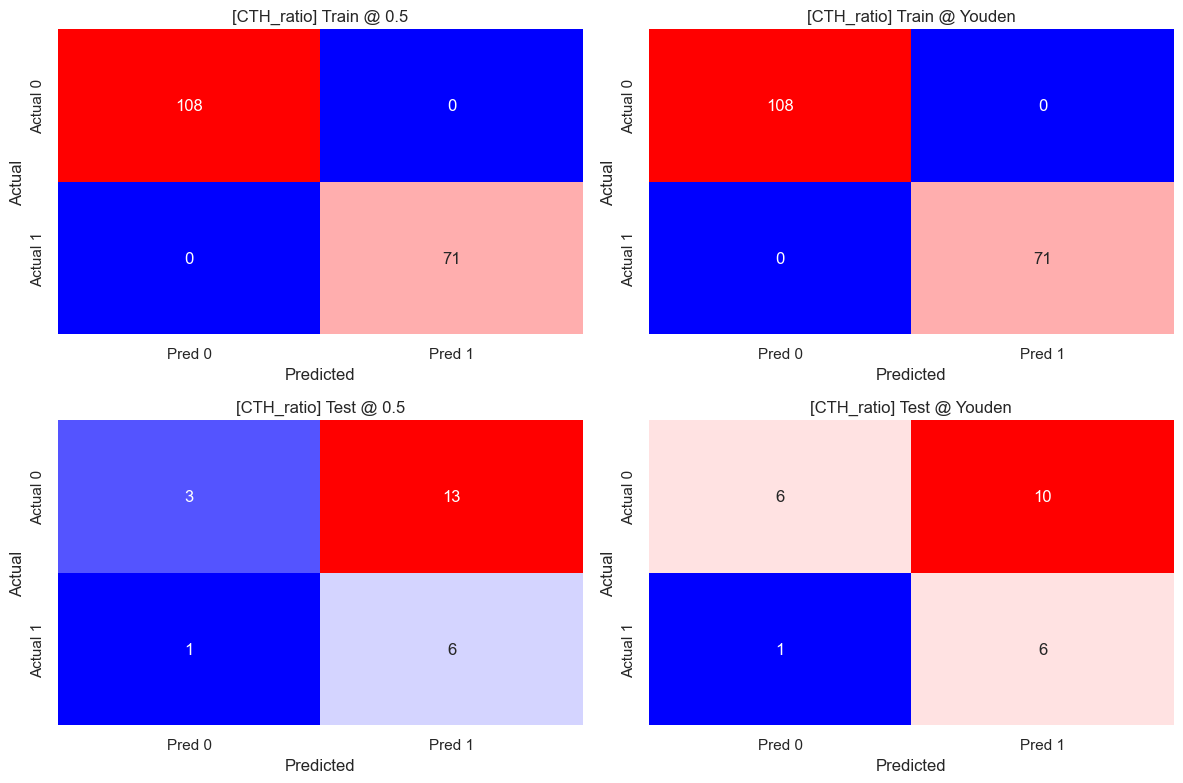

C:\Users\maichi\work\my_projects\CercareStatAnalysis\metrics.py:144: RuntimeWarning: overflow encountered in exp
  y_lower = 1 / (1 + np.exp(-lower_logit))


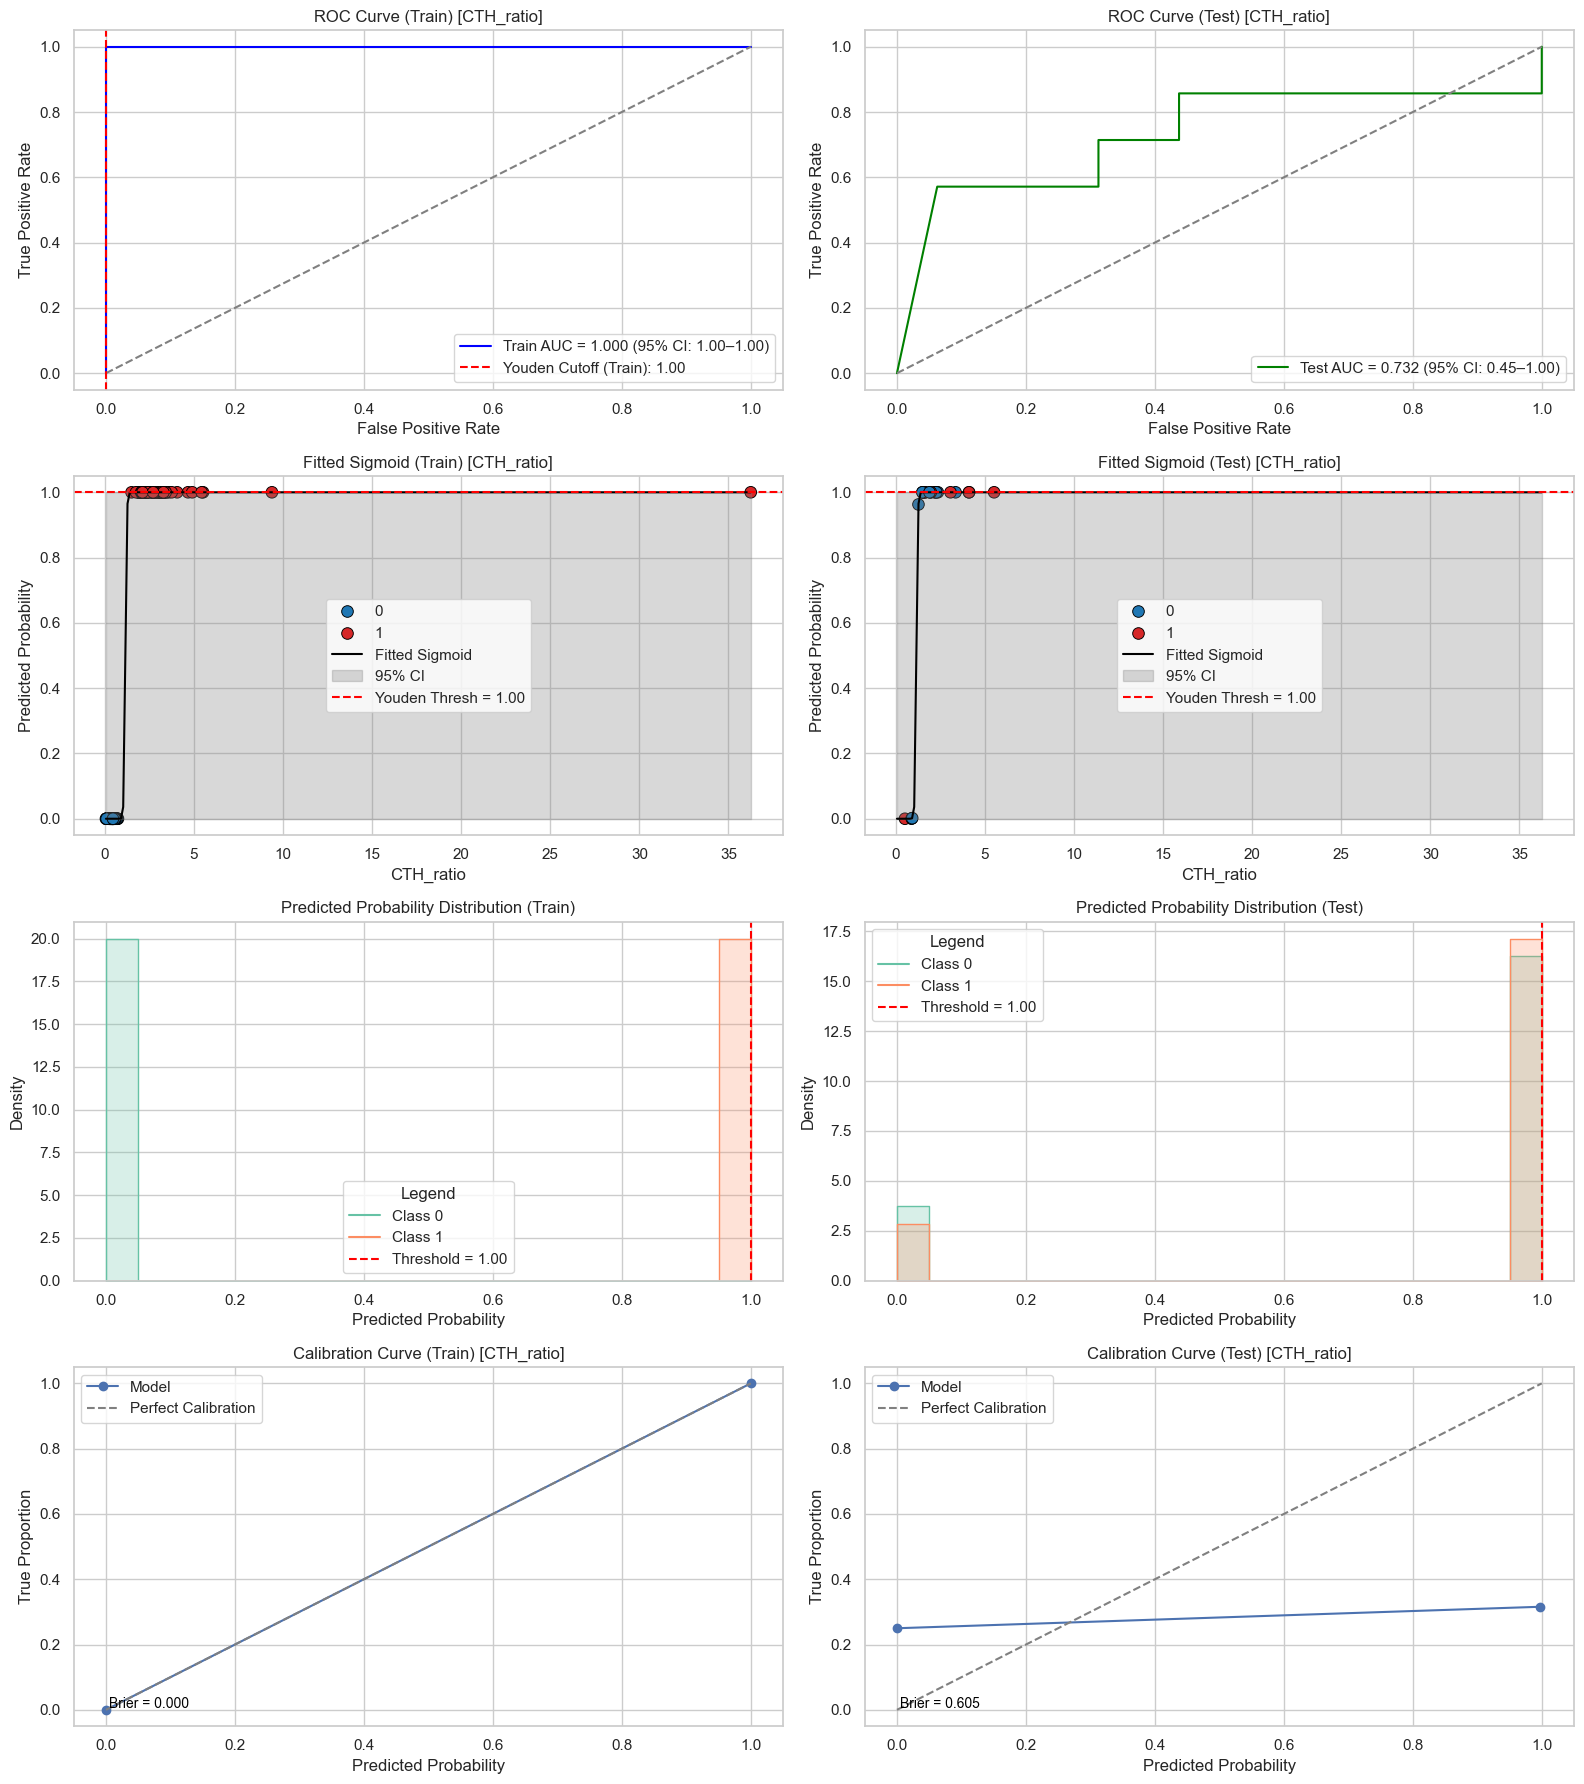

In [20]:
ub.evaluate_logistic_univariate_model(feature=ub.ratio,  target_bin_count=20)

### 5.2 Bivariate Logistic Regression 

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
BIVARIATE LOGISTIC REGRESSION: CTH_lésion + CTH_control
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.750 (95% CI: 0.472 – 1.000)
Optimal Threshold (Youden’s J): 1.000

▶ [CTH_LÉSION + CTH_CONTROL] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [CTH_LÉSION + CTH_CONTROL] TRAIN @ YOUDEN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |

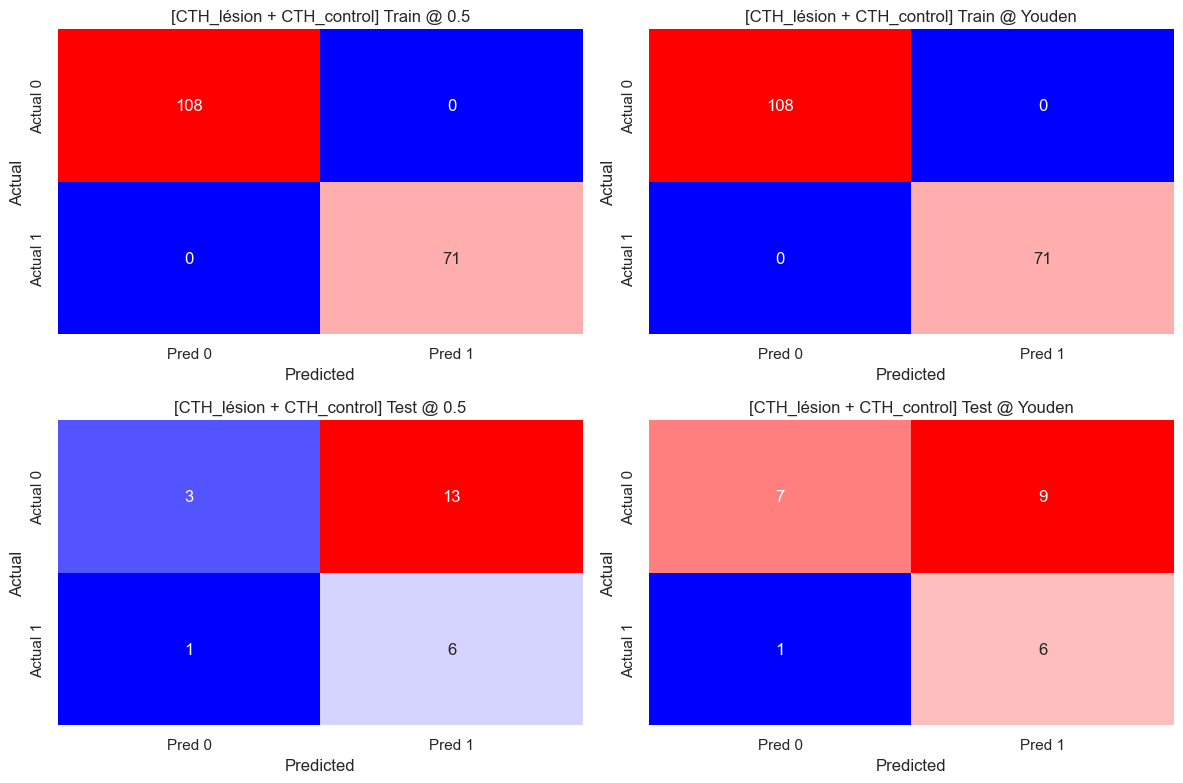

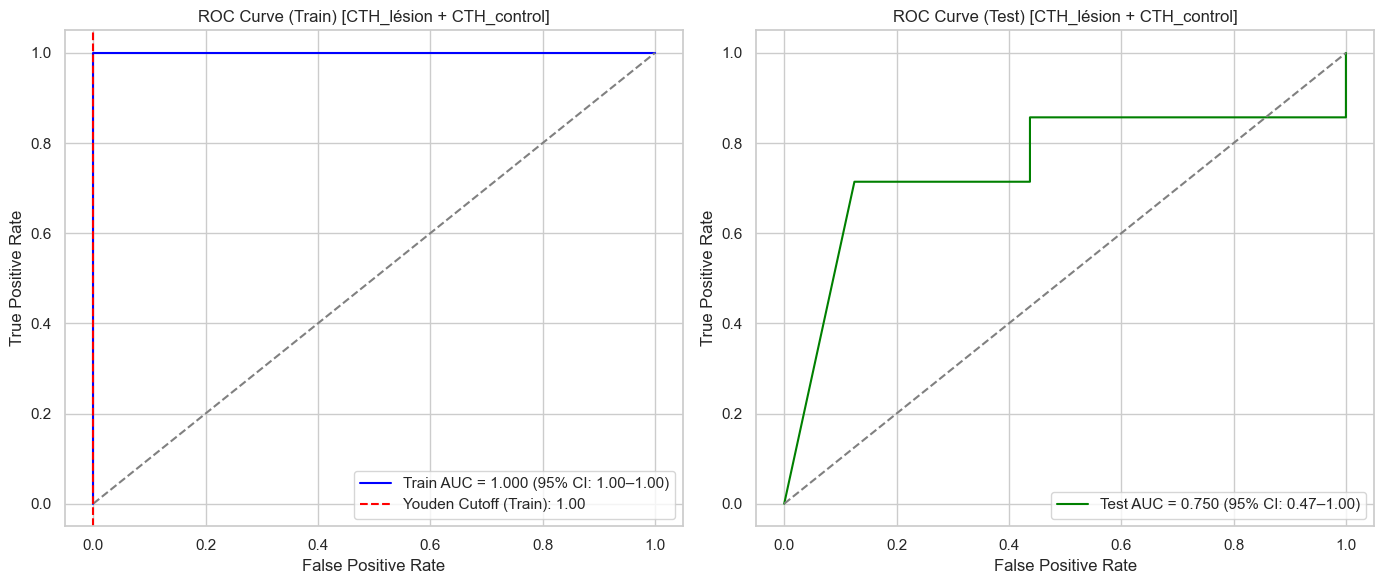

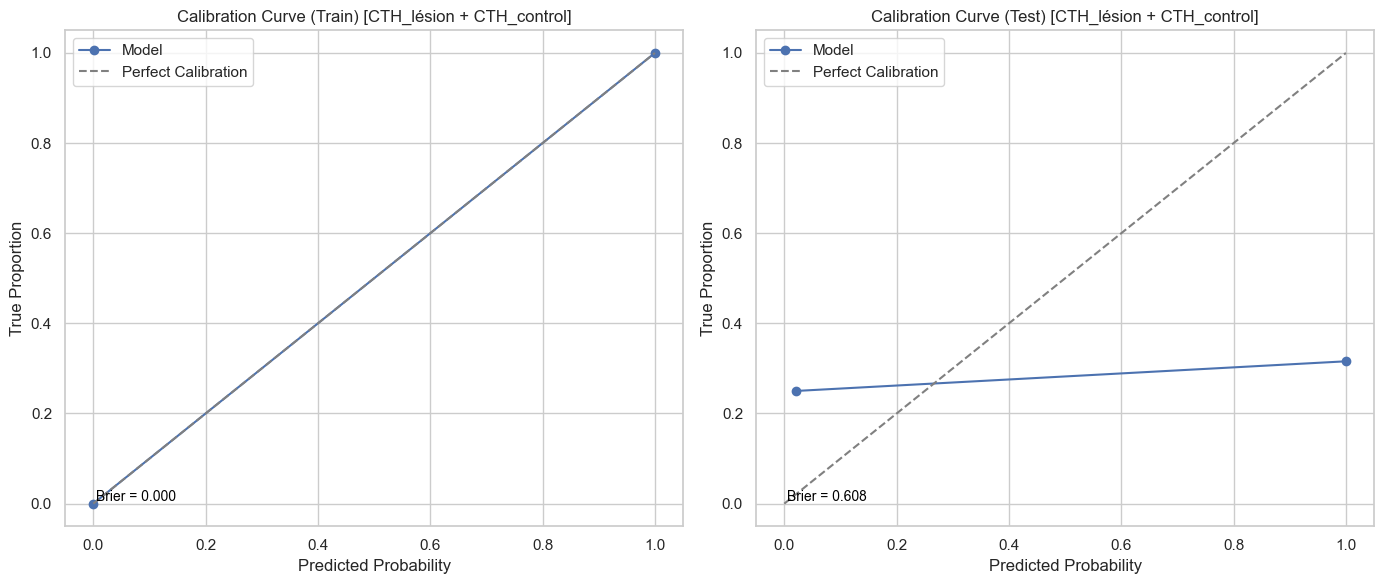

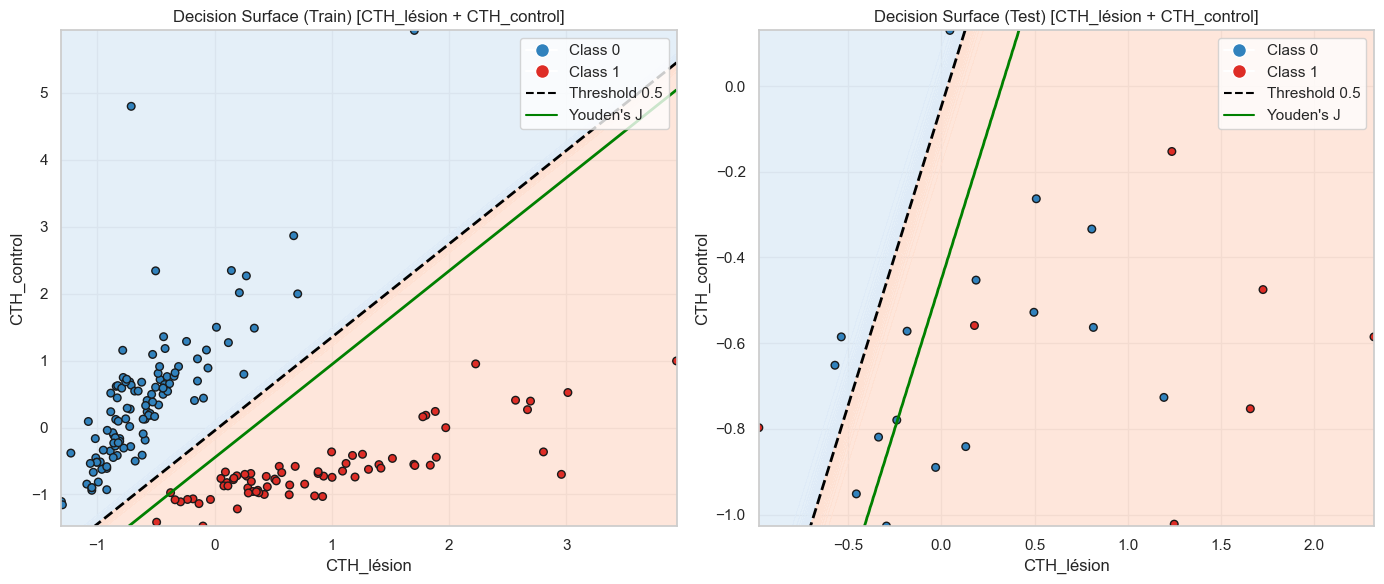

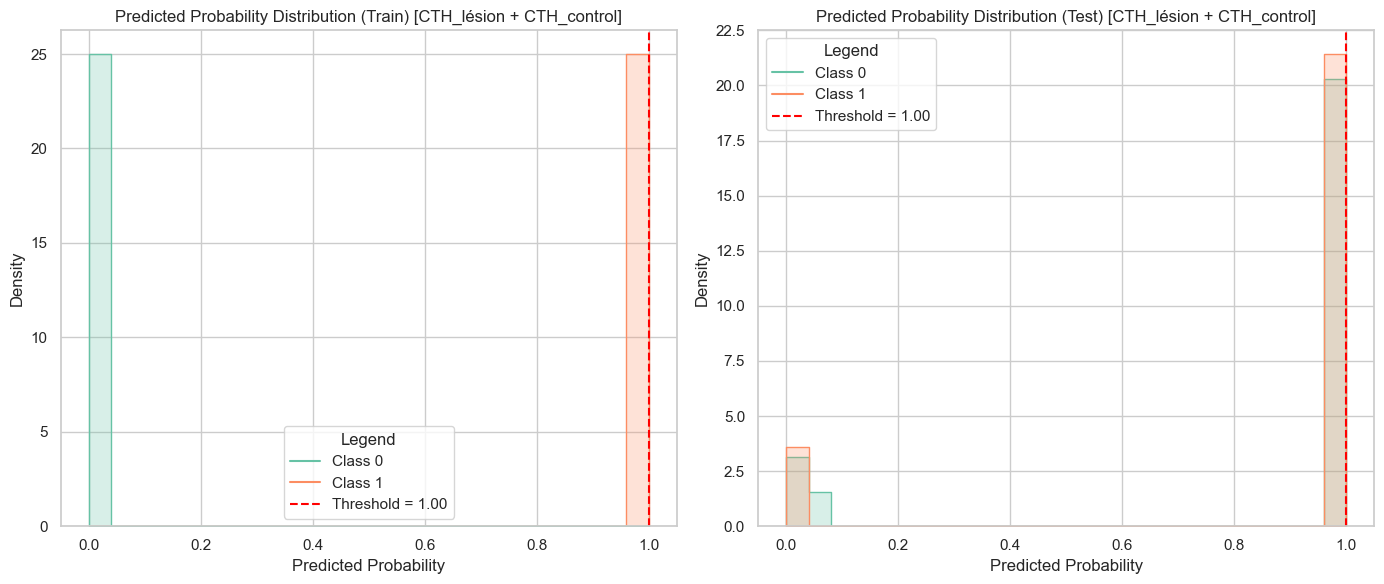

In [21]:
ub.evaluate_logistic_bivariate_model(target_bin_count=25)

## 5.  SVM Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
SVM (LINEAR) BIVARIATE: CTH_lésion + CTH_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Margin] Test  AUC : 0.786 (95% CI: 0.500 – 1.000)
Optimal Margin Cutoff (Youden): 0.532
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Proba]  Test  AUC : 0.786 (95% CI: 0.500 – 1.000)
Optimal Proba  Cutoff (Youden): 0.740

▶ [CTH_LÉSION + CTH_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Sco

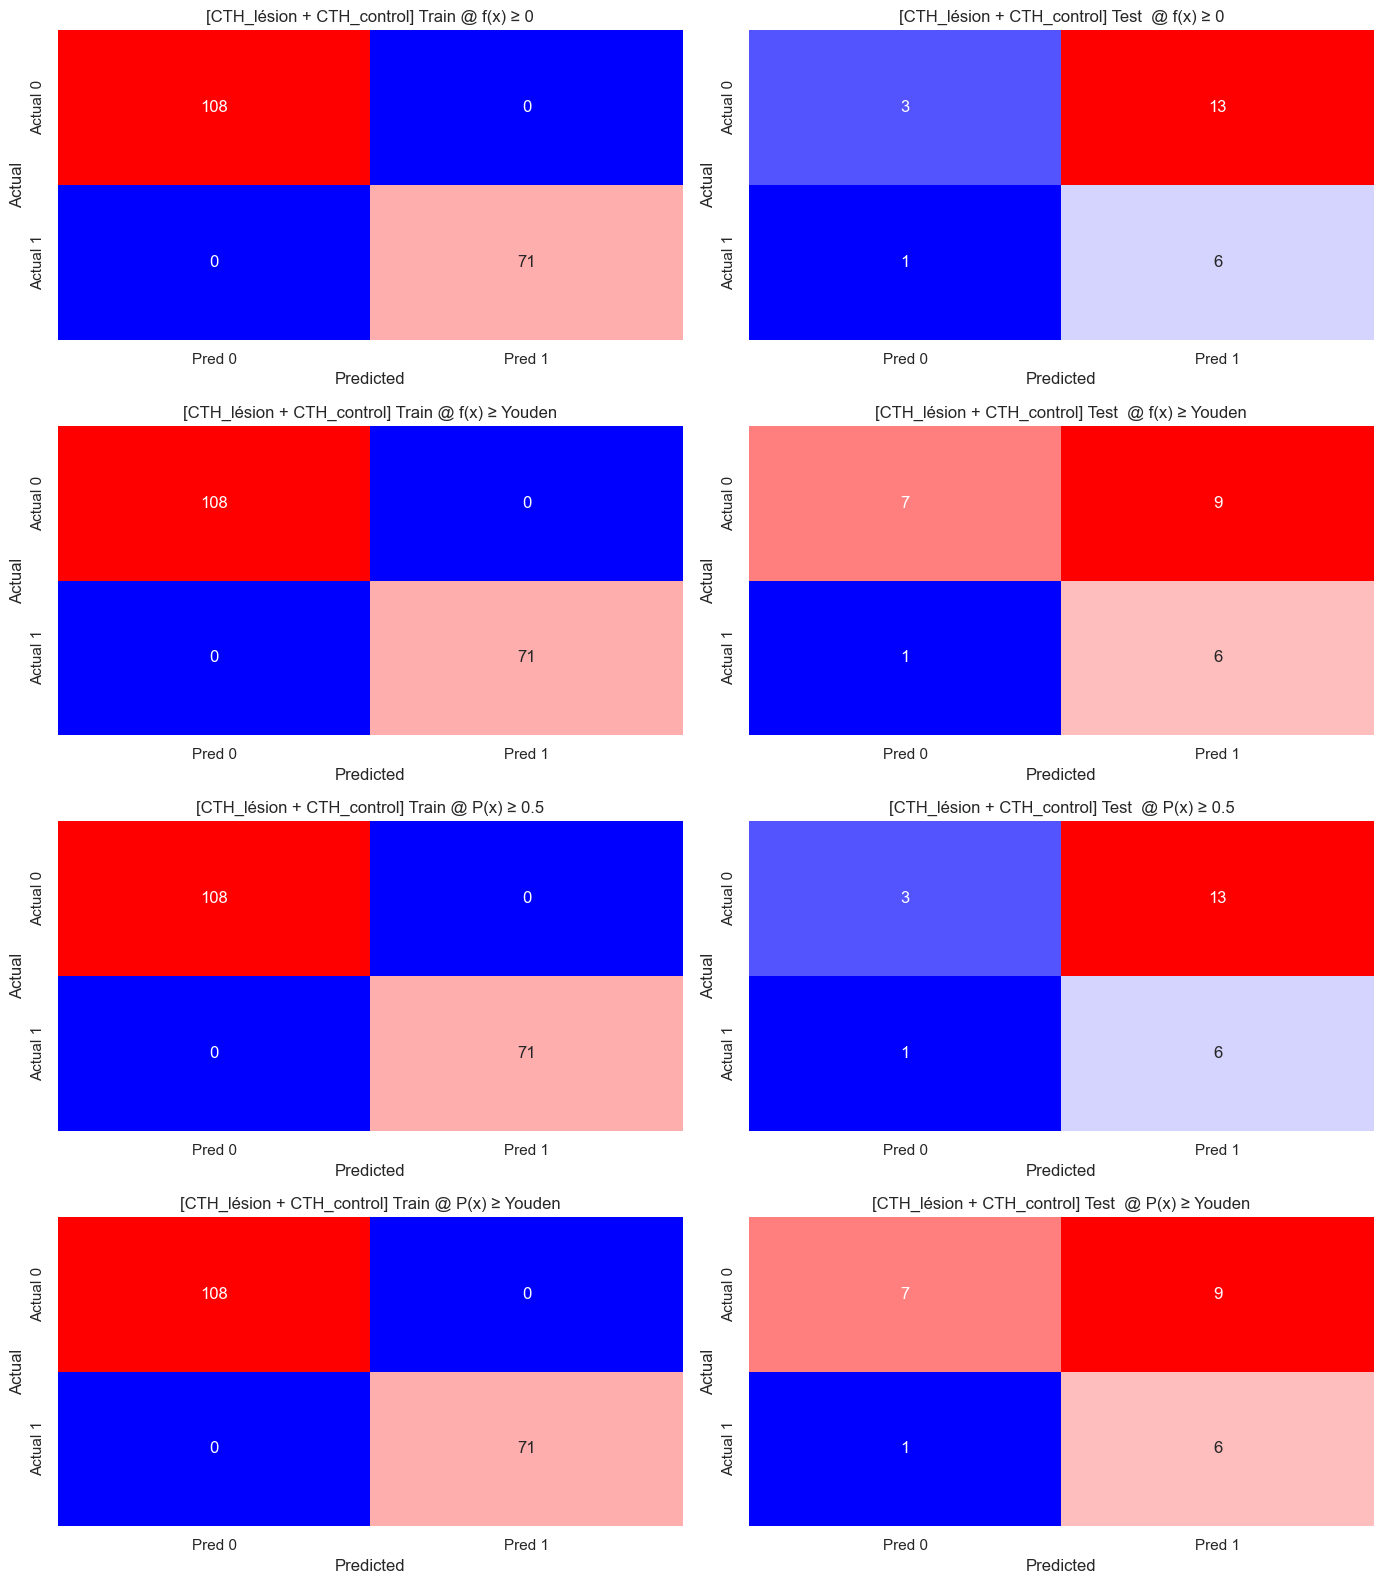

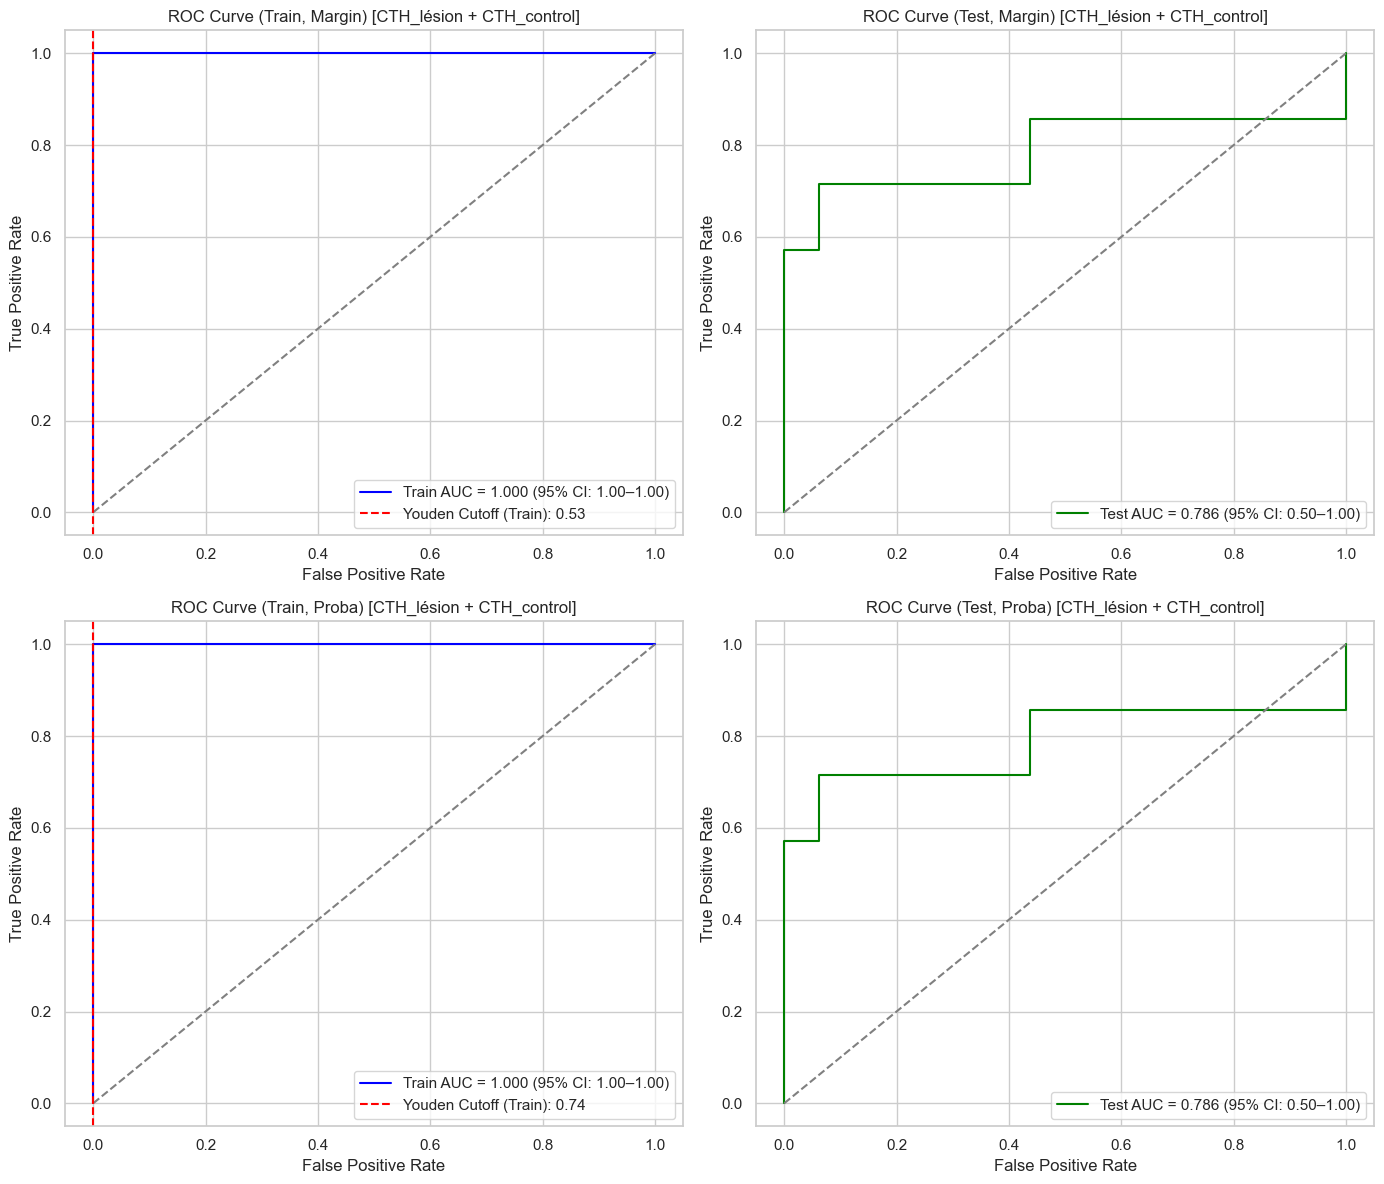

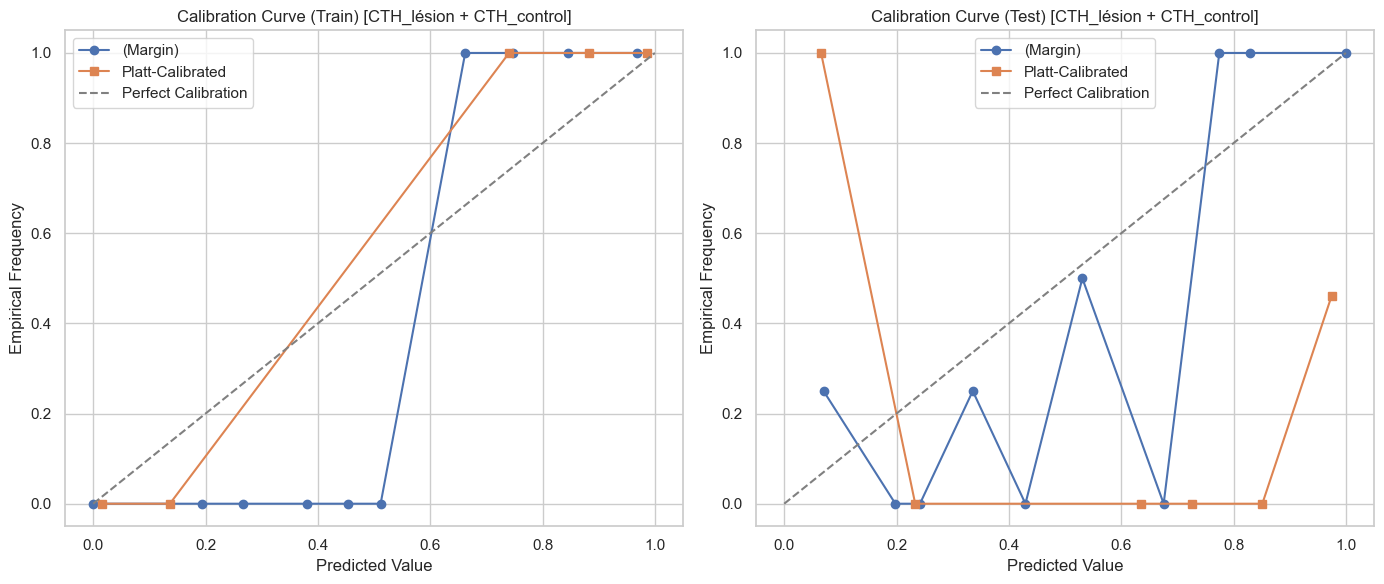

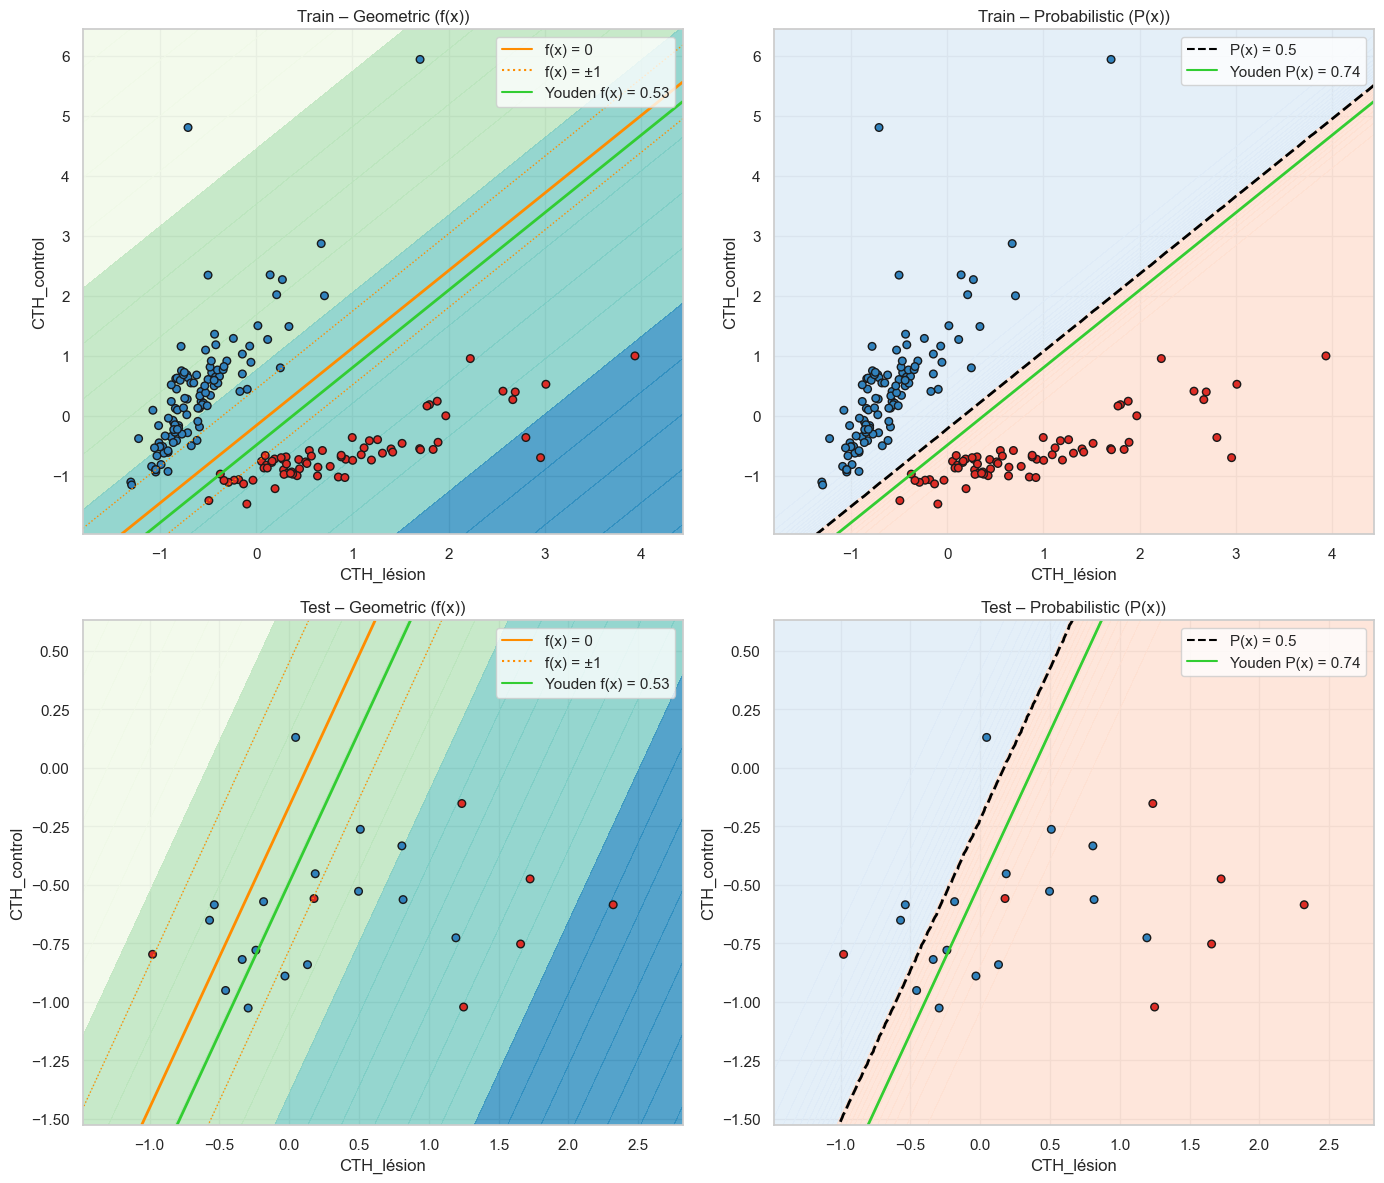

In [22]:
ub.evaluate_svm_bivariate_model(kernel="linear")

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
SVM (RBF) BIVARIATE: CTH_lésion + CTH_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Margin] Test  AUC : 0.598 (95% CI: 0.326 – 0.871)
Optimal Margin Cutoff (Youden): 0.609
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Proba]  Test  AUC : 0.598 (95% CI: 0.326 – 0.871)
Optimal Proba  Cutoff (Youden): 0.879

▶ [CTH_LÉSION + CTH_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score 

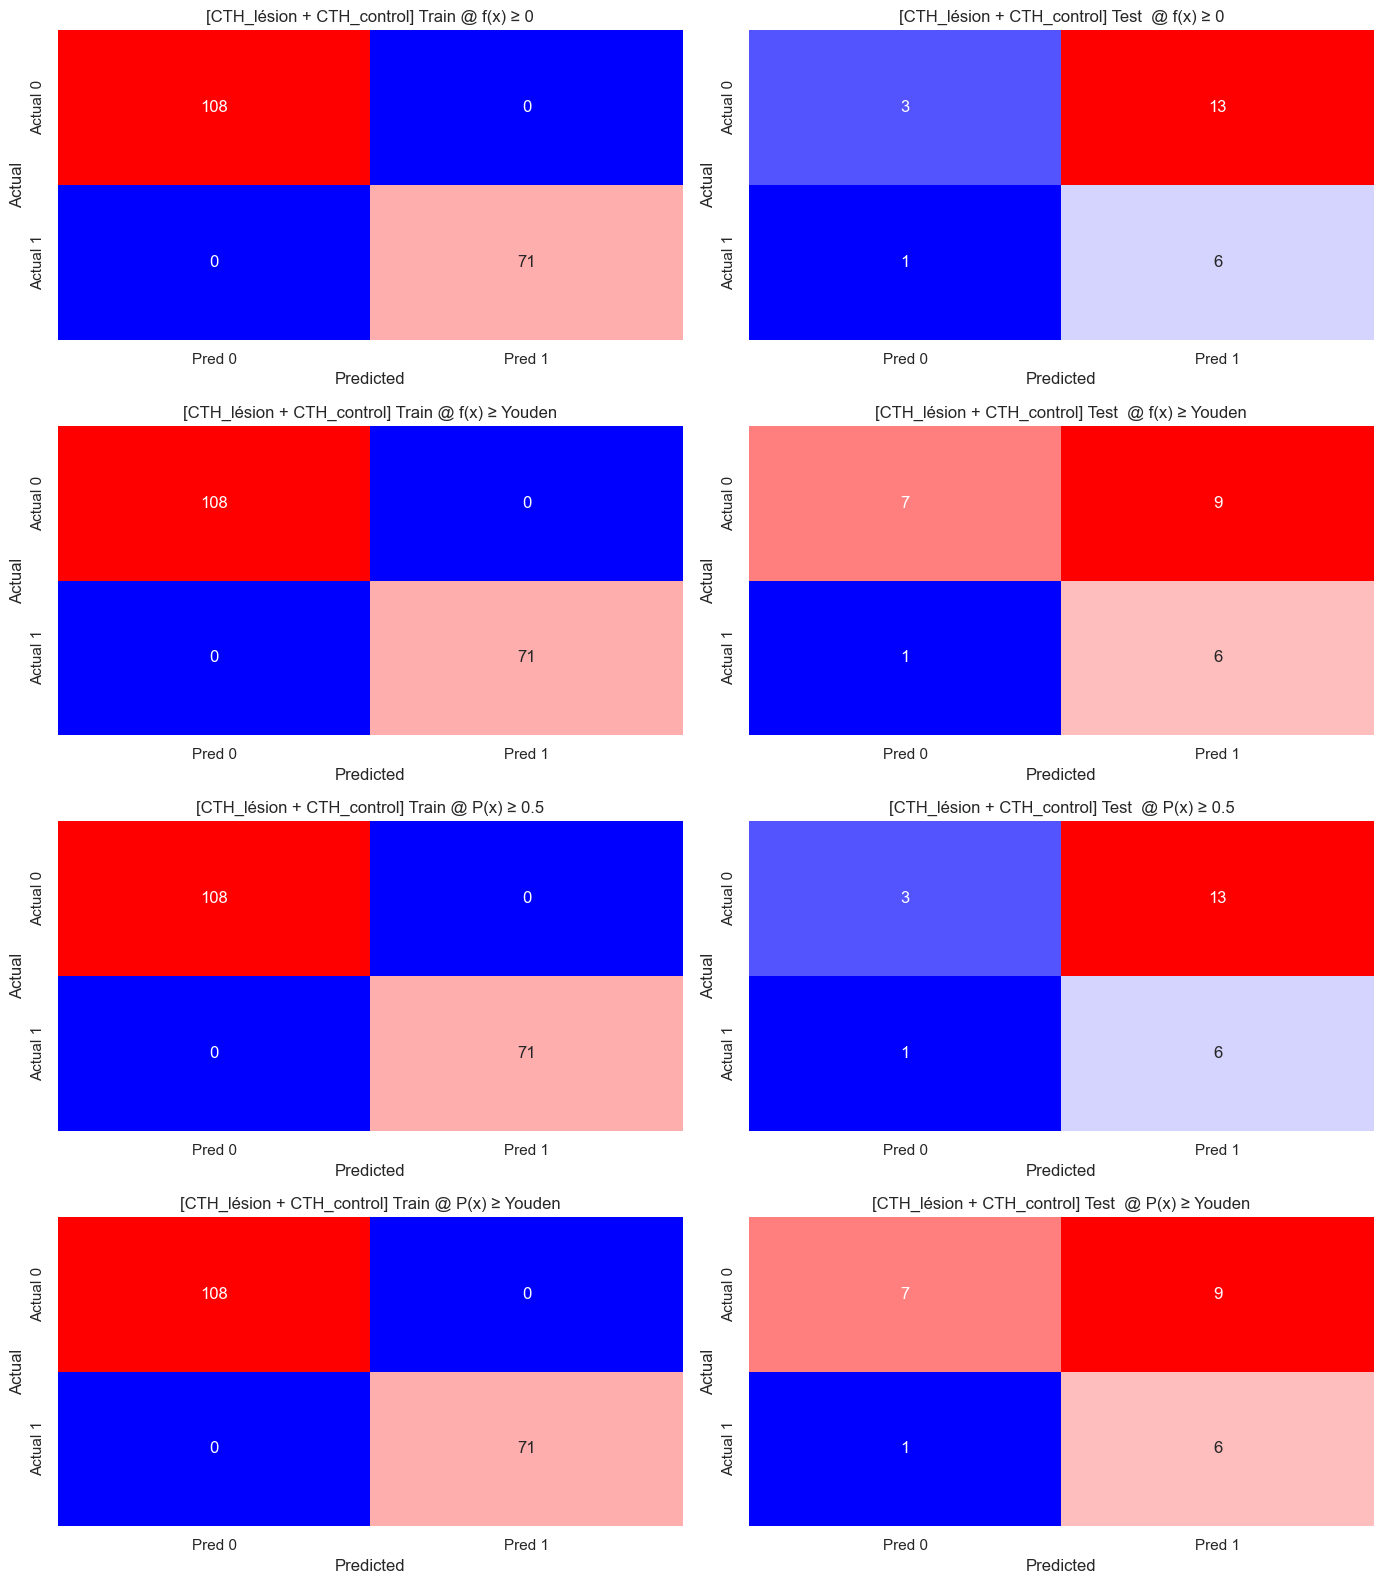

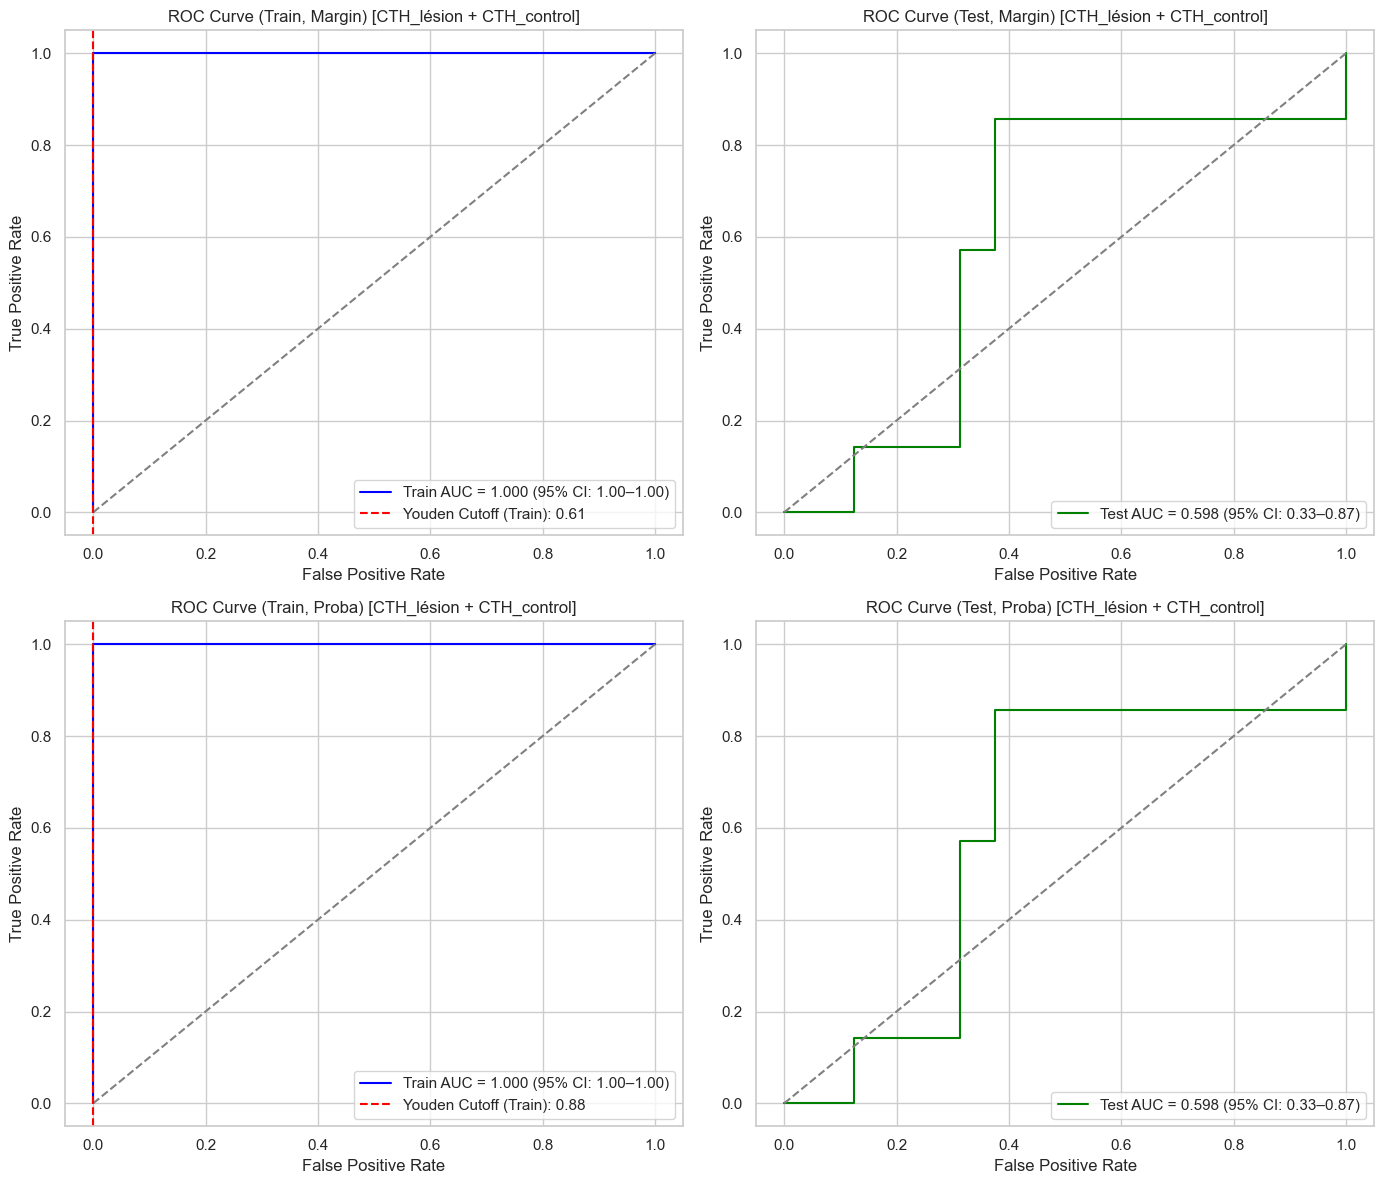

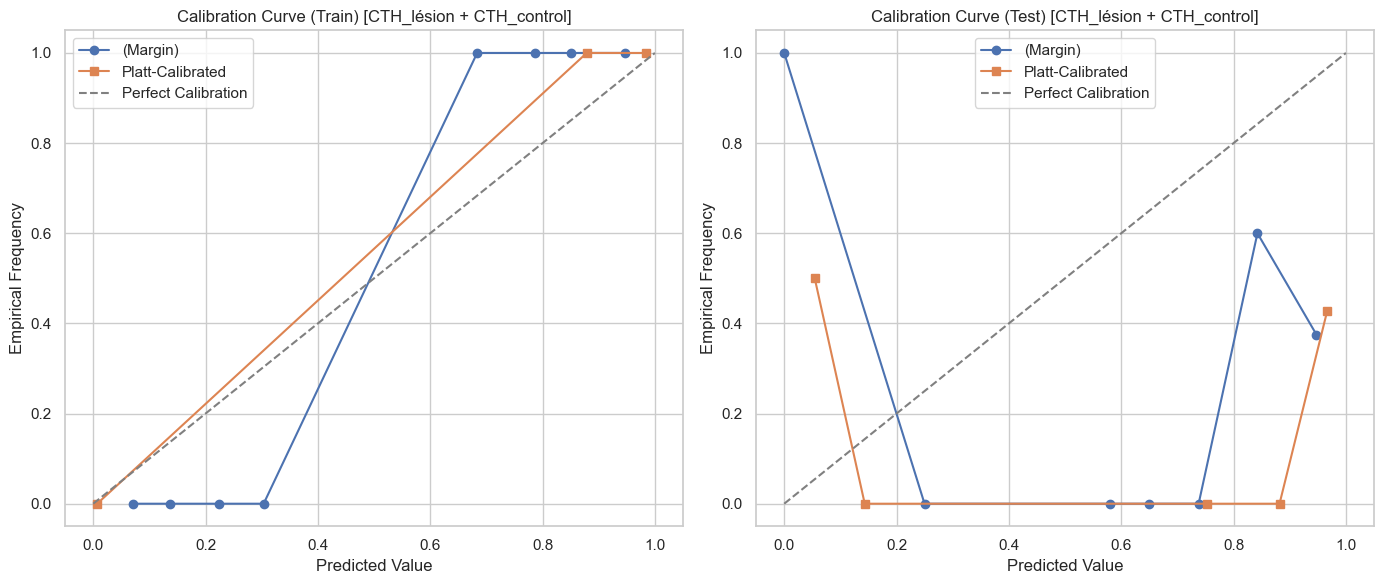

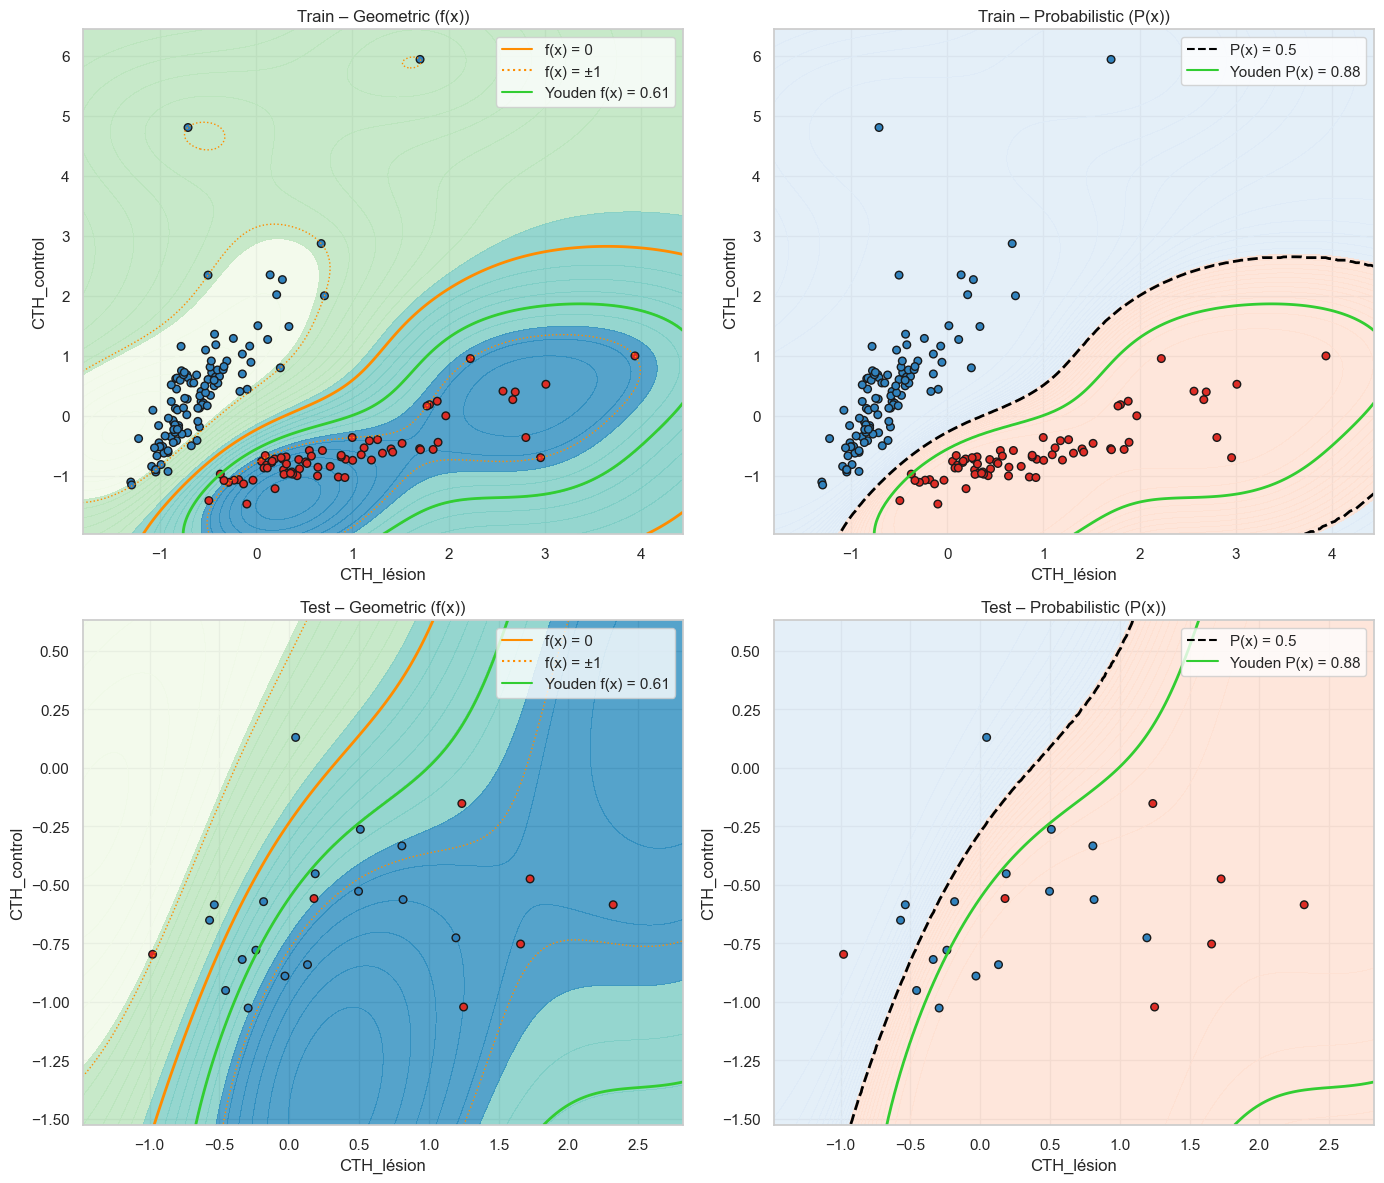

In [23]:
ub.evaluate_svm_bivariate_model(kernel="rbf")

## 6.  Decision Tree Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
DECISION TREE (max_depth=3, criterion=GINI): CTH_lésion + CTH_control + CTH_ratio
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.522 (95% CI: 0.351 – 0.694)
----------------------------------------------------------------------------------------------------

▶ [CTH_LÉSION + CTH_CONTROL + CTH_RATIO] TRAIN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [CTH_LÉSION + CTH_CONTROL + CTH_RATIO] TEST
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |  

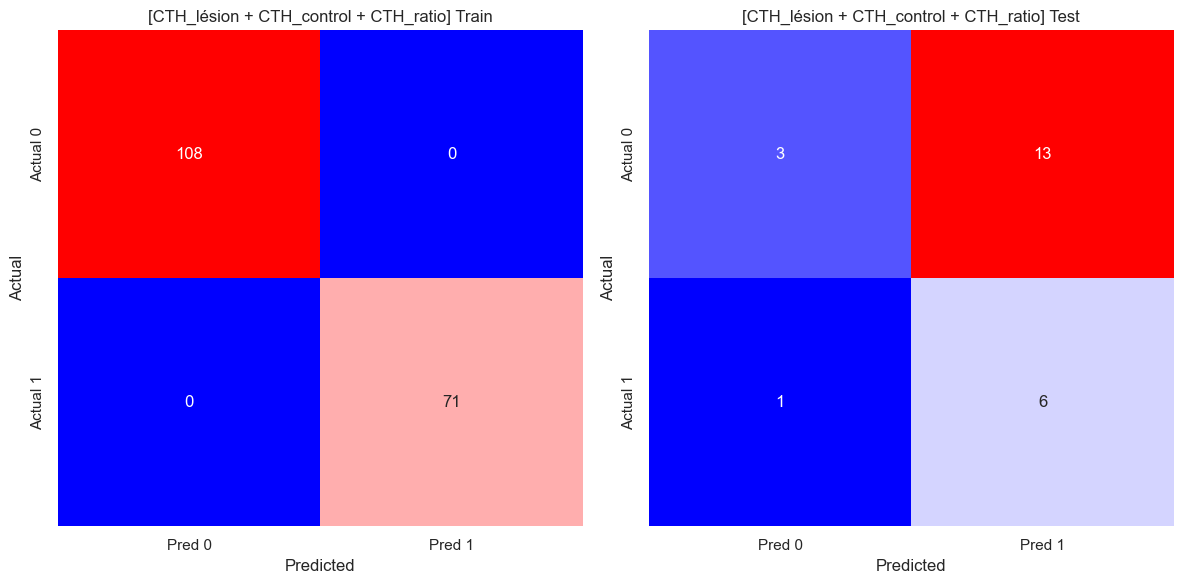

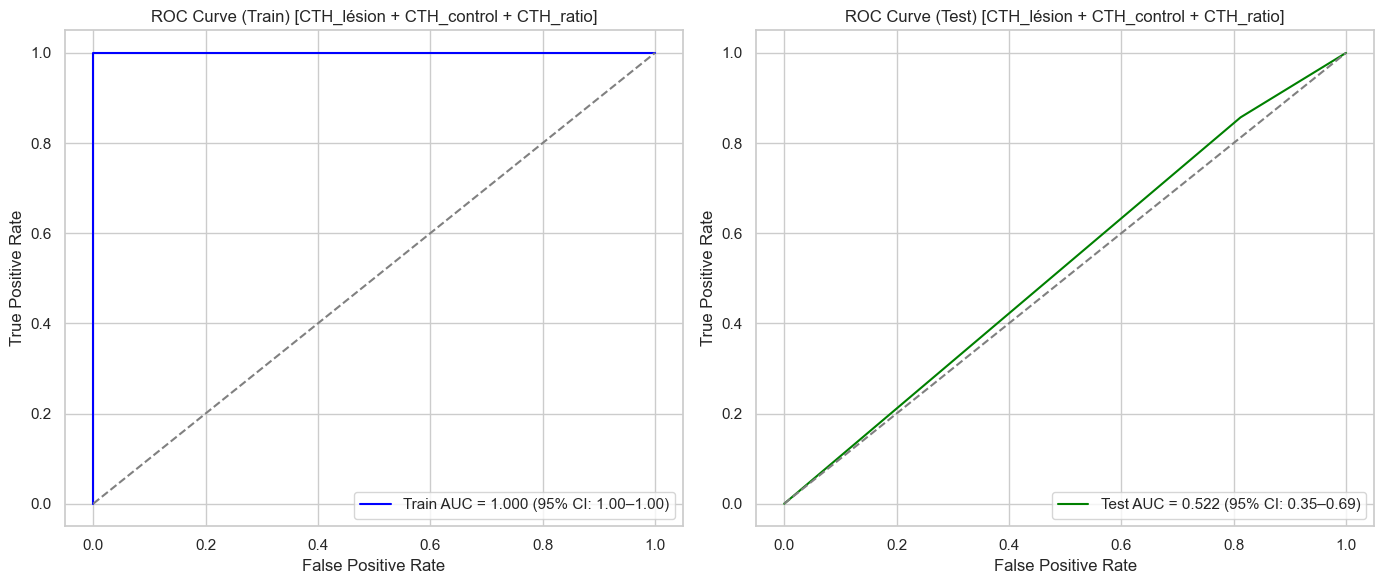

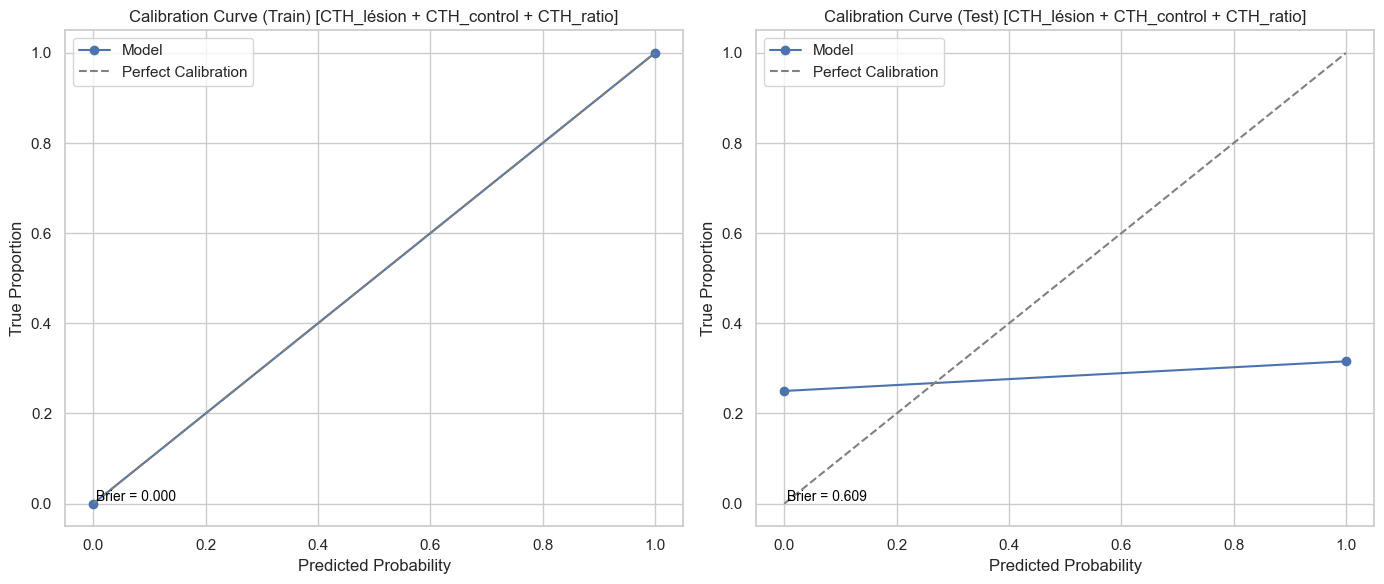

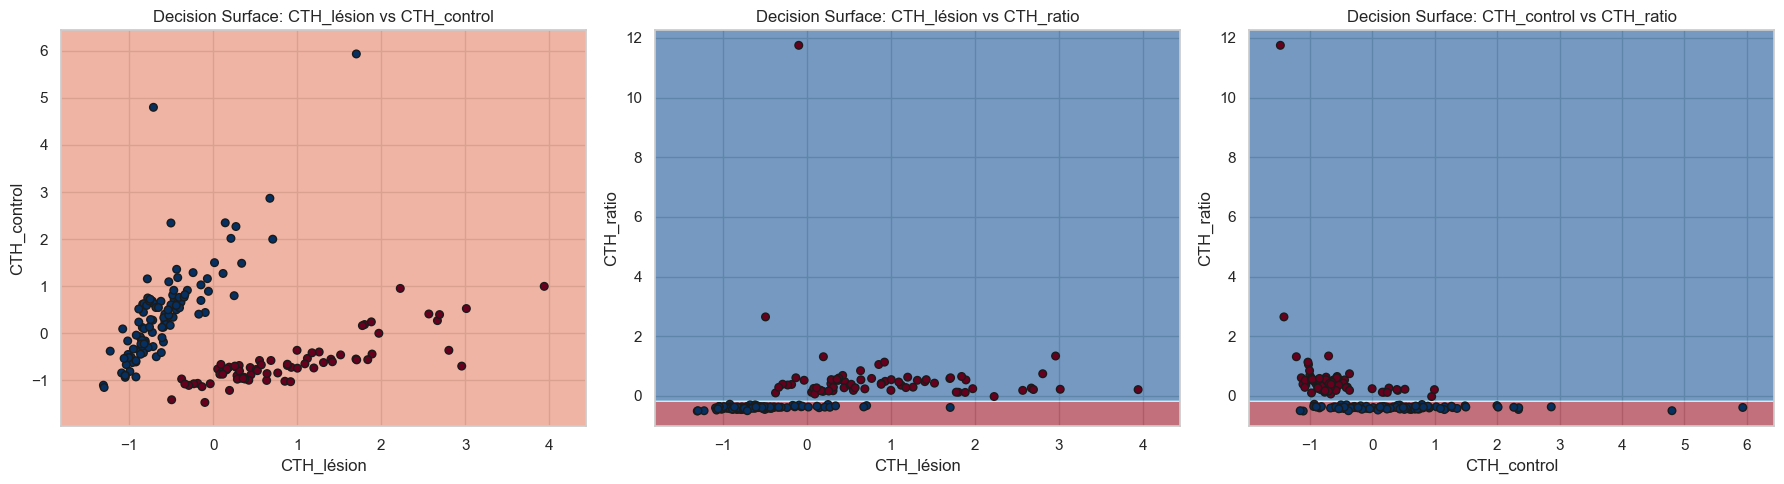

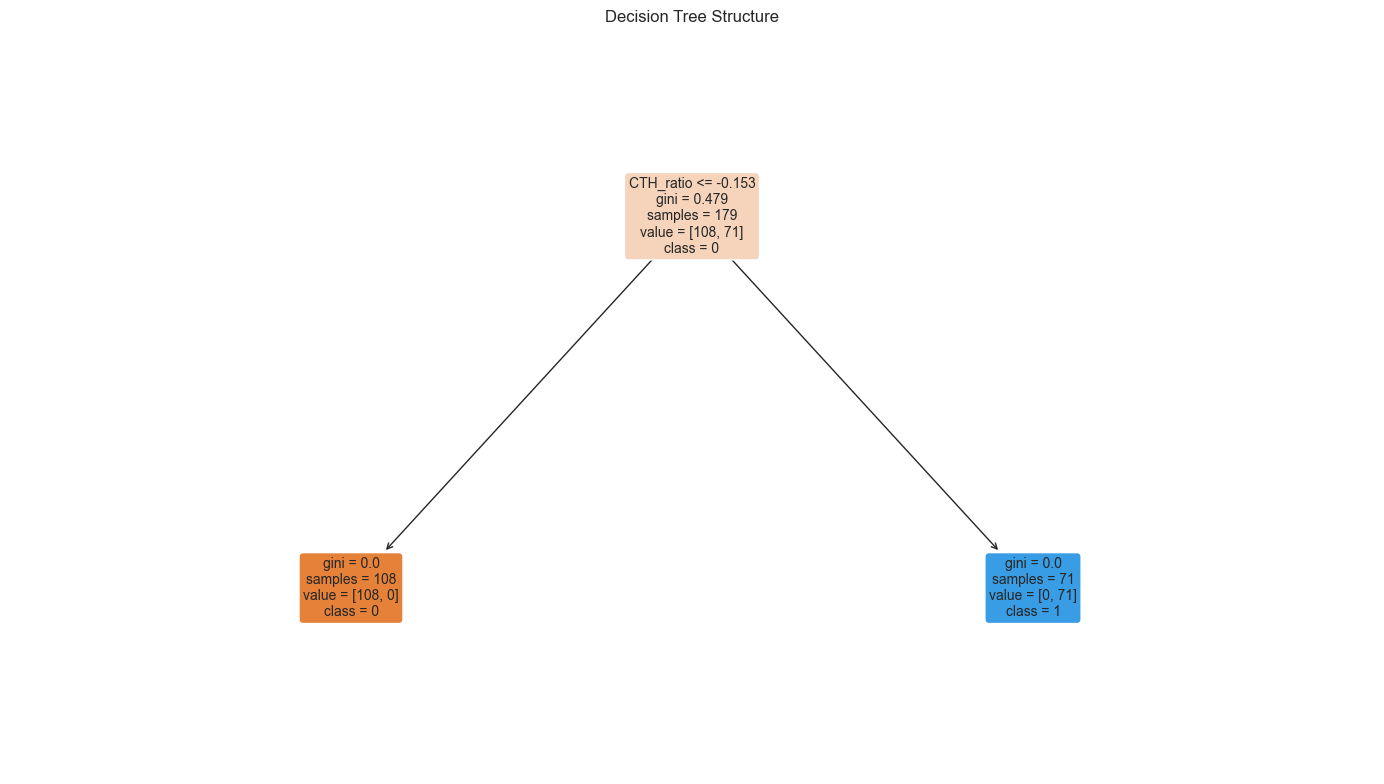


Tree Rules :
--------------------------------------------------------------------------------
|--- CTH_ratio <= -0.15
|   |--- class: 0
|--- CTH_ratio >  -0.15
|   |--- class: 1



In [24]:
ub.evaluate_tree_trivariate_model()